In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import matplotlib.lines as lines
import seaborn as sns
%matplotlib inline

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

import scanpy

# Data

## Exploration

In [2]:
! cat '/oak/stanford/groups/pritch/users/magu/data/GWPS-Replogle/processed/info.txt'

This dataset includes data from three Perturb-seq experiments described in Replogle et al. 2022 (https://doi.org/10.1016/j.cell.2022.05.013): 

    1. K562 genome-scale perturb-seq sampled at day 8 post-transduction (K562_gwps)
    2. K562 essential-scale perturb-seq sampled at day 6 post-transduction (K562_essential)
    3. RPE1 essential-scale perturb-seq sampled at day 7 post-transduction (rpe1)

For each dataset, there are four processed Perturb-seq files in AnnData format (https://anndata.readthedocs.io/en/latest/).

    1. Raw, single-cell expression data for genes expressed at >0.01 UMI per cell (named $pop_raw_singlecell_01.h5ad)
    2. Raw, pseudo-bulk expression data for genes expressed at >0.01 UMI per cell (named $pop_raw_bulk_01.h5ad)
    3. gemgroup Z-normalized single-cell expression data for genes expressed at >0.01 UMI per cell (named $pop_normalized_singlecell_01.h5ad)
    4. gemgroup Z-normalized pseudo-bulk expression data for genes expressed at >0.01 UMI per cell (

In [3]:
root = '/oak/stanford/groups/pritch/users/magu/data/GWPS-Replogle'
raw_bulk = os.path.join(root, 'processed', 'K562_gwps_raw_bulk_01.h5ad')
norm_bulk = os.path.join(root, 'processed', 'K562_gwps_normalized_bulk_01.h5ad')
norm_sc = os.path.join(root, 'processed', 'K562_gwps_normalized_singlecell_01.h5ad')

# .var annotation details genes 
# .obs annotation details single-cells/pseudobulk populations.

bulk_r = scanpy.read_h5ad(raw_bulk, backed='r').to_memory()
bulk = scanpy.read_h5ad(norm_bulk, backed='r').to_memory()
sc = scanpy.read_h5ad(norm_sc, backed='r')

sc.shape, bulk.shape, bulk_r.shape

((1989578, 8248), (11258, 8248), (11258, 8248))

In [4]:
! echo -n C; cat '/oak/stanford/groups/pritch/users/magu/data/GWPS-Replogle/supplement/info.txt'

Commonly requested supplemental files supporting the publication:  

Mapping information-rich genotype-phenotype landscapes with genome-scale Perturb-seq, Replogle, Joseph M. et al. Cell, Volume 185, Issue 14, 2559 - 2575.e28 https://doi.org/10.1016/j.cell.2022.05.013:


1) All Anderson-Darling p-values for differential expression analysis


2) Embedding coordinates for Figure 2D


3) Downloadable interactive scatter plot of Fig. 2D


4) Z-normalized expression data used to make Figs. 2 and 4, annotated with the cluster identities from Supplementary Table 3


In [5]:
# 1) All Anderson-Darling p-values for differential expression analysis

pvalues = pd.read_csv(os.path.join(root, 
                                   'supplement', 
                                   'anderson-darling p-values, BH-corrected.csv.gz'),
                      index_col=0)
display(pvalues.shape, pvalues.iloc[:3,:3])

(5530, 11258)

,1946_CTSC_P1P2_ENSG00000109861,1973_CWC25_P1P2_ENSG00000273559,6168_PDE4DIP_ENST00000313431.9_ENSG00000178104
ENSG00000188976,0.867552,0.430562,0.873442
ENSG00000187608,0.953630,0.547279,0.954249
ENSG00000078808,0.999979,0.305927,0.953442


Show that the p-value subset contains target gemes with expression above 0.25 UMI / cell.

In [6]:
bulk.var['ad_tested'] = bulk.var.index.isin(pvalues.index)
bulk.var.head()

,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv,ad_tested
gene_id,,,,,,,,,,
ENSG00000237491,LINC01409,0.114359,0.033798,0.295547,True,0.153642,0.117205,0.034833,0.297200,False
ENSG00000228794,LINC01128,0.178166,0.040590,0.227822,True,0.122999,0.182778,0.041933,0.229419,False
ENSG00000188976,NOC2L,1.375142,0.162536,0.118196,True,0.063150,1.411069,0.164344,0.116468,True
ENSG00000187961,KLHL17,0.102961,0.030863,0.299751,True,0.162265,0.105230,0.031627,0.300552,False
ENSG00000188290,HES4,0.237189,0.057237,0.241315,True,0.127442,0.242638,0.058972,0.243044,False


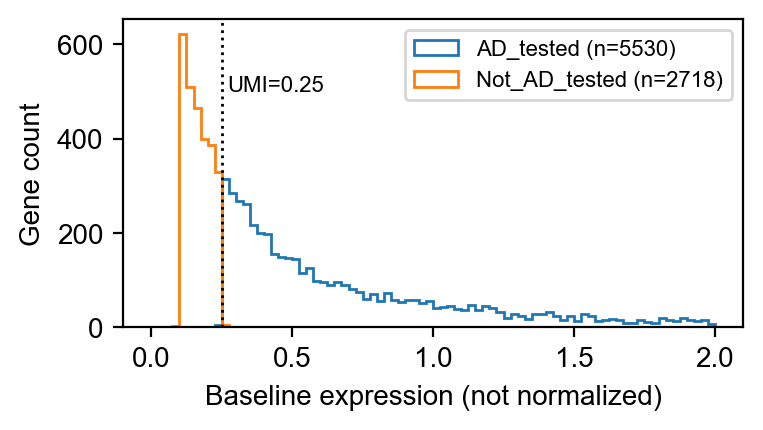

In [7]:
plt.figure(figsize=(4,2), dpi=200);
plt.hist(bulk.var.query('ad_tested')['mean'].clip(upper=2.1), bins=np.linspace(0,2,81), histtype='step', label='AD_tested (n={})'.format(bulk.var.ad_tested.sum()));
plt.hist(bulk.var.query('~ad_tested')['mean'].clip(upper=2.1), bins=np.linspace(0,2,81), histtype='step', label='Not_AD_tested (n={})'.format((~bulk.var.ad_tested).sum()));
plt.xlabel('Baseline expression (not normalized)'); plt.ylabel('Gene count'); 
plt.legend(fontsize=8);
plt.axvline(0.25, linewidth=1, color='k', linestyle='dotted'); 
plt.text(0.27, 500, 'UMI=0.25', fontsize=8);
#plt.xticks([0, 0.5, 1, 1.5, 2]);

In [8]:
# 4) Z-normalized expression data used to make Figs. 2 and 4, 
#     annotated with the cluster identities from Supplementary Table 3

means = pd.read_csv(root+'/supplement/clustered_mean_gene_expression_figs2-4.csv.gz', header=[0,1], index_col=[0,1])

display(means.shape, means.columns[:5], means.index[:5], means.iloc[:3,:3])

(2319, 1973)

MultiIndex([(    '10005_ZBTB4_P1_ENSG00000174282', '19'),
            (  '10006_ZBTB5_P1P2_ENSG00000168795', '-1'),
            ('10015_ZBTB8OS_P1P2_ENSG00000176261', '-1'),
            ( '10020_ZC3H13_P1P2_ENSG00000123200',  '4'),
            ( '10023_ZC3H18_P1P2_ENSG00000158545', '-1')],
           names=['gene_transcript', 'cluster'])

MultiIndex([('CYP51A1',  4),
            (    'BAD', -1),
            (   'CD99', -1),
            ( 'MAD1L1', 29),
            (  'CFLAR', 19)],
           names=['gene_name', 'cluster'])

,gene_transcript,10005_ZBTB4_P1_ENSG00000174282,10006_ZBTB5_P1P2_ENSG00000168795,10015_ZBTB8OS_P1P2_ENSG00000176261
,cluster,19,-1,-1
gene_name,cluster,,,
CYP51A1,4,0.015538,-0.169297,-0.141619
BAD,-1,0.075532,-0.039656,-0.133556
CD99,-1,-0.185194,0.067921,0.138278


## Main analysis subset

Corresponds to non-control guide RNAs that target primary transcripts which were also measured in the experiment. There are a couple duplicate guides that need to be removed (we pick the ones that had higher efficacy in knocking down the target transcript).

In [9]:
pd.Series([g.split('_')[-1] for g in pvalues.columns if g.split('_')[-1] in pvalues.index]).value_counts().shape, \
pvalues.shape, \
pd.Series([g.split('_')[-1] for g in pvalues.columns if g.split('_')[-1] in pvalues.index and 'P1' in g.split('_')[2]]).value_counts().shape 
#.to_frame().rename(columns={0:'guides'}).query('guides > 1').index

((5316,), (5530, 11258), (5247,))

In [10]:
# first one shows there are duplicates, second one removes them

# iterate over guides, check that they're non-control, target primary, and measured in the experiment
pd.Series([g.split('_')[-1] for g in pvalues.columns if ~bulk.obs.loc[g,'core_control'] and 'P1' in g.split('_')[2] and g.split('_')[-1] in pvalues.index]).value_counts()

ENSG00000103363    2
ENSG00000150527    2
ENSG00000134107    2
ENSG00000145337    1
ENSG00000130935    1
                  ..
ENSG00000204713    1
ENSG00000074582    1
ENSG00000136240    1
ENSG00000085415    1
ENSG00000110931    1
Length: 5247, dtype: int64

In [11]:
for t in ['ENSG00000103363','ENSG00000150527','ENSG00000134107']:
    display(pvalues.loc[t, [g for g in pvalues.columns if t in g and 'P1' in g.split('_')[2]]])

8770_ELOB_P1P2_ENSG00000103363    5.851270e-279
8769_ELOB_P1P2_ENSG00000103363     4.237974e-01
Name: ENSG00000103363, dtype: float64

5047_MIA2_P1P2_ENSG00000150527    9.992363e-01
1922_MIA2_P1P2_ENSG00000150527    1.204519e-07
Name: ENSG00000150527, dtype: float64

8535_BHLHE40_P1P2_ENSG00000134107    9.982998e-01
830_BHLHE40_P1P2_ENSG00000134107     8.442446e-15
Name: ENSG00000134107, dtype: float64

In [12]:
remove = ['8769_ELOB_P1P2_ENSG00000103363','5047_MIA2_P1P2_ENSG00000150527','8535_BHLHE40_P1P2_ENSG00000134107']

guides, genes = zip(*[(g,g.split('_')[-1]) for g in pvalues.columns if ~bulk.obs.loc[g,'core_control'] \
                                                                    and 'P1' in g.split('_')[2] \
                                                                    and g.split('_')[-1] in pvalues.index \
                                                                    and g not in remove
                     ])

# Pandas DataFrame, with symmetric rows and columns -- the diagonal has meaning!!
p = pvalues.loc[genes, guides]
display(p.shape, pd.concat((p.columns[:5].to_series().reset_index()[0], p.index[  :5].to_series().reset_index()[0]), axis=1))

(5247, 5247)

,0,0
0,1946_CTSC_P1P2_ENSG00000109861,ENSG00000109861
1,1973_CWC25_P1P2_ENSG00000273559,ENSG00000273559
2,8210_SNAPIN_P1P2_ENSG00000143553,ENSG00000143553
3,7183_RBM6_P1P2_ENSG00000004534,ENSG00000004534
4,2209_DHX33_P1P2_ENSG00000005100,ENSG00000005100


In [13]:
np.diag(p < 0.05).sum()

4610

In [14]:
((pvalues < 0.05).sum(axis=0) > 0).mean()

0.698969621602416

In [15]:
((p < 0.05).sum(axis=0) > 0).mean()

0.9317705355441205

In [16]:
(((p < 0.05) ^ np.diag(np.diag(p < 0.05))).sum(axis=0) > 0).mean()

0.7091671431294073

## Transcriptional effects subset

Make a graph among the subset of genes.

In [17]:
# NetworkX Graph -- no self loops!

ko_ix = (bulk.obs.loc[p.columns, 'energy_test_p_value'] < 1e-3).values
#R = nx.from_numpy_array((p.iloc[ko_ix, ko_ix] < 5e-2).values.T, create_using=nx.DiGraph())
#R = nx.relabel_nodes(R, dict(enumerate(p.iloc[ko_ix, ko_ix].index)))

R = nx.from_numpy_array((p < 5e-2).values.T, create_using=nx.DiGraph())
R = nx.relabel_nodes(R, dict(enumerate(p.index)))
R.remove_edges_from(nx.selfloop_edges(R))

# sanity check
ko, gene = list(R.edges())[5]

(ko, 
 gene, 
 p.loc[gene, [g for g in p.columns if ko in g]].item() < 5e-2, 
 p.loc[ko, [g for g in p.columns if gene in g]].item() < 5e-2,
 sum(ko_ix)
)

('ENSG00000004534', 'ENSG00000134287', True, False, 2152)

In [18]:
(
    R.number_of_nodes(),
    int(2 * scipy.special.comb(R.number_of_nodes(), 2)), 
    R.number_of_edges(), 
    R.number_of_edges()/int(2 * scipy.special.comb(R.number_of_nodes(), 2)),
    int(sum([(b,a) in R.edges for (a,b) in R.edges])/2),
    2*int(sum([(b,a) in R.edges for (a,b) in R.edges])/2) / R.number_of_edges()
)

(5247, 27525762, 865719, 0.03145122739926328, 20621, 0.047639014507016714)

# Figure 1

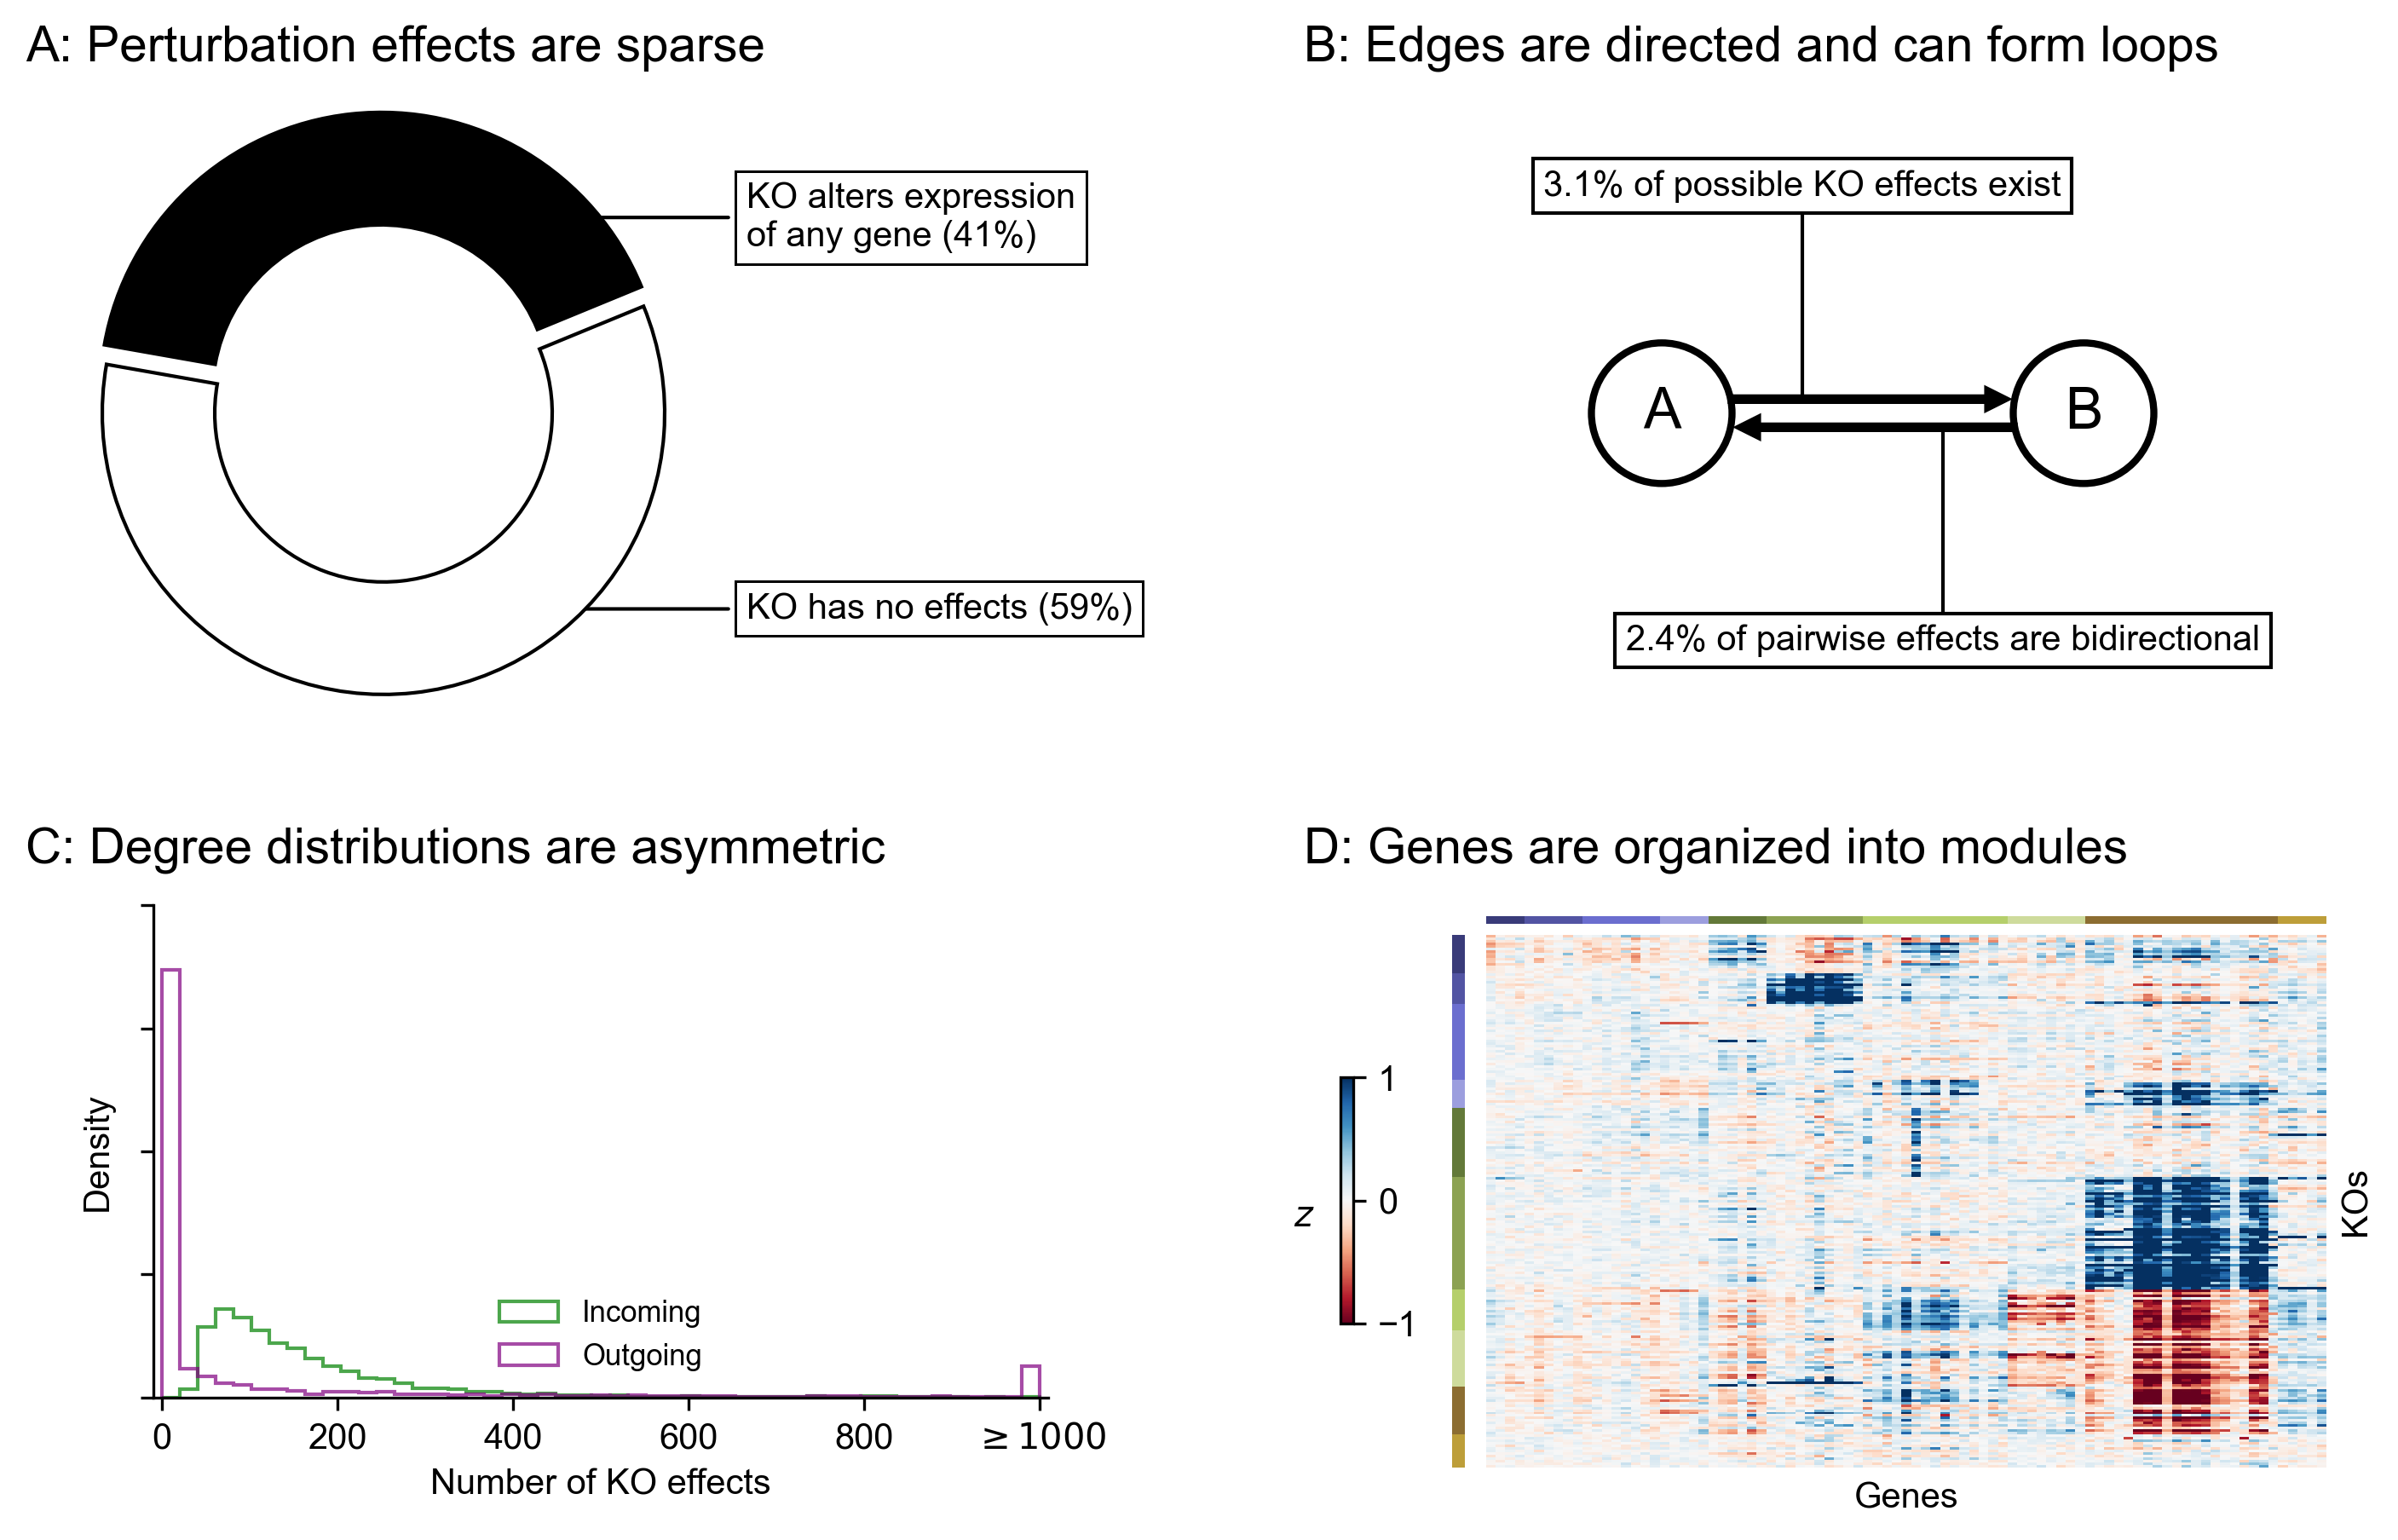

In [19]:
### 1D
df = means.loc[(slice(None), range(0,10)), (slice(None), map(str,range(0,10)))].fillna(0).T.sort_values('cluster').T

cm = dict(enumerate(plt.get_cmap('tab20b').colors))

cg = sns.clustermap(df, 
                    row_cluster=False, 
                    col_cluster=False, 
                    row_colors=[cm.get(int(s) % 20) for s in df.index.get_level_values('cluster')], 
                    col_colors=[cm.get(int(s) % 20) for s in df.columns.get_level_values('cluster')],
                    colors_ratio=0.015,
                    cbar_pos=None,
                    dendrogram_ratio=0.0,
                    cmap='RdBu', vmin=-1, vmax=1, center=0, figsize=(4,6)
                    )

cg.ax_heatmap.set_xticks([]);
cg.ax_heatmap.set_yticks([]);
cg.ax_heatmap.set_ylabel('KOs');
cg.ax_heatmap.set_xlabel('Genes');
cg.figure.set_dpi(300); 
cg.fig.subplots_adjust(0.55, 0.0, 0.9, 0.4) # left, bottom, right, top




## 1A
ax = cg.fig.add_axes([0.0, 0.5, 0.5, 0.5]) # left, bottom, width, height

p1 = bulk.obs.loc[p.columns,:]
p1_n = p1.shape[0]
p1_fx = (p1['energy_test_p_value'] < 1e-3).sum()
p1_f = p1_fx / p1_n
p1_med = p1.query('energy_test_p_value < 1e-3')['anderson_darling_counts'].median()

labels = ["KO has no effects ({0:.0f}%)".format(100*(1 - p1_f)), 
          "KO alters expression\nof any gene ({0:.0f}%)".format(100*p1_f)
          #"Transcriptional effect ({0:.0f}%)\nMedian downstream: {1:.0f}".format(100*p1_f, p1_med)]
         ]

data = [1 - p1_f, p1_f]

wedges, texts = ax.pie(data, 
                            wedgeprops=dict(width=0.4, 
                                            linewidth=1,
                                            edgecolor="black"), 
                            startangle=170, 
                            colors=['white','black'],
                            explode=[0, 0.07]
                            )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = 'left'# {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], 
                     xy=(x, y), 
                     #xytext=(-0.3*np.sign(x), 1.4*y),
                     xytext=(12*np.abs(x), 0.7*y),
                     horizontalalignment=horizontalalignment, 
                     **kw)


ax.set_xlim(-0.25, 2.25);



## 1B
ax = cg.fig.add_axes([0.5, 0.5, 0.5, 0.5]) # left, bottom, width, height

# Create nodes A and B as circles
r=0.1
circle_a = plt.Circle((0.2, 0.5), r, facecolor='white', edgecolor='black', linewidth=2)
circle_b = plt.Circle((0.8, 0.5), r, facecolor='white', edgecolor='black', linewidth=2)

# Add the circles to the plot
ax.add_patch(circle_a)
ax.add_patch(circle_b)
ax.text(0.2, 0.5, 'A', ha='center', va='center', color='black', fontsize=16)
ax.text(0.8, 0.5, 'B', ha='center', va='center', color='black', fontsize=16)

# Add arrows
hw,hl=0.02,0.02
arrow_ab = ax.arrow(0.2+r, 0.5+hw,  0.6-hl-(2*r)-0.015, 0, 
                     color='black', 
                     linewidth=2.5,
                     head_width=hw, 
                     head_length=hl)
arrow_ba = ax.arrow(0.8-r, 0.5-hw, -0.6+hl+(2*r)+0.015, 0, 
                     color='black', 
                     linewidth=2.5,
                     head_width=hw, 
                     head_length=hl)

# Add text boxes with labels

nc2 = scipy.special.comb(R.number_of_nodes(), 2)
m = int(R.number_of_edges())
mm = int(sum([(b,a) in R.edges for (a,b) in R.edges])/2)

text_box_ab = ax.text(0.4, 0.8, 
                      '{:.1f}% of possible KO effects exist'.format(50*m/nc2), 
                      ha='center', va='bottom', 
                      bbox=dict(boxstyle='square', facecolor='white', edgecolor='black'))
text_box_ba = ax.text(0.6, 0.2, 
                      '{:.1f}% of pairwise effects are bidirectional'.format(100*mm/(m-mm)), 
                      ha='center', va='top', 
                      bbox=dict(boxstyle='square', facecolor='white', edgecolor='black'))

# Draw lines connecting text boxes to arrows
line_ab = ax.vlines(0.4, 0.5+hw, 0.8, linewidth=1, color='black')
line_ba = ax.vlines(0.6, 0.2, 0.5-hw, linewidth=1, color='black')

# Set axis limits
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1)

# Remove axis ticks and labels
ax.set_xticks([]); 
ax.set_yticks([]); 
ax.set_xticklabels([]); 
ax.set_yticklabels([]); ax.set_frame_on(False)

# Set aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')


### 1C
ax = cg.fig.add_axes([0.05, 0.05, 0.35, 0.35]) # left, bottom, width, height

out_ko = np.sum(p < 5e-2, axis=0)
inc_ko = np.sum(p < 5e-2, axis=1)

xm=1000

ax.hist(inc_ko.clip(0, xm), 
             bins=np.linspace(0, xm, 50),
             histtype='step',
             alpha=0.7,
             color='green',
             label='Incoming');

ax.hist(out_ko.clip(0, xm), 
             bins=np.linspace(0, xm, 50),
             histtype='step', 
             alpha=0.7,
             color='purple',
             label='Outgoing');

ax.set_xlim(-10, xm+10);
ax.legend(fontsize='small', loc='lower center', frameon=False);
ax.set_xlabel('Number of KO effects'); 
ax.set_ylabel('Density');
ax.set_yticks(ax.get_yticks()); 
ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);
ax.set_xticks([0,200,400,600,800,1000]); 
ax.set_xticklabels(['0','200','400','600','800',r'$\geq1000$']);
ax.set_title(' ');
sns.despine(ax=ax);



cg.fig.set_figheight(5.5);
cg.fig.set_figwidth(10);

cg.fig.text(0, 1, 'A: Perturbation effects are sparse', fontsize=14, weight='bold');
cg.fig.text(0.5, 1, 'B: Edges are directed and can form loops', fontsize=14, weight='bold');
cg.fig.text(0, 0.43, 'C: Degree distributions are asymmetric', fontsize=14, weight='bold');
cg.fig.text(0.5, 0.43, 'D: Genes are organized into modules', fontsize=14, weight='bold');

# this is a horrible hack, please don't be mad at me 
cbar = cg.fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1), cmap='RdBu'),
                     anchor=(3.5,0.3), pad=-0.15, shrink=0.5)
cbar.ax.set_ylabel(r'$z$', rotation=0, labelpad=-32);

# done
cg.savefig('png/fig1.png');

# Extras

## Sparsity

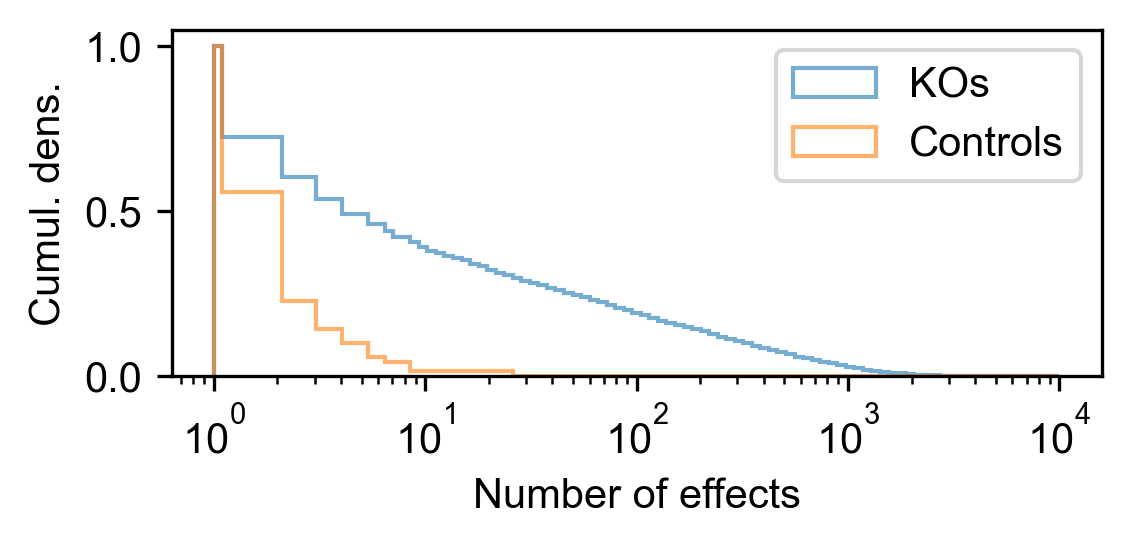

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4,1.5), dpi=300)

plt.hist(bulk.obs.query('~core_control')['mann_whitney_counts'], 
         histtype='step', 
         bins=np.logspace(0, 4, 100), 
         cumulative=-1, 
         density=True, 
         log=False,
         alpha=0.6,
         label='KOs'); 

plt.hist(bulk.obs.query('core_control')['mann_whitney_counts'], 
         histtype='step', 
         bins=np.logspace(0, 4, 100), 
         cumulative=-1, 
         density=True, 
         log=False,
         alpha=0.6,
         label='Controls'); 

plt.xlabel('Number of effects'); plt.ylabel('Cumul. dens.'); plt.legend();

plt.semilogx();

count    2152.000000
mean      425.869888
std       727.887518
min         0.000000
25%        35.000000
50%       137.000000
75%       483.000000
max      5450.000000
Name: anderson_darling_counts, dtype: float64 count    5247.000000
mean      176.754908
std       510.325939
min         0.000000
25%         1.000000
50%         5.000000
75%        78.000000
max      5450.000000
Name: anderson_darling_counts, dtype: float64 2152


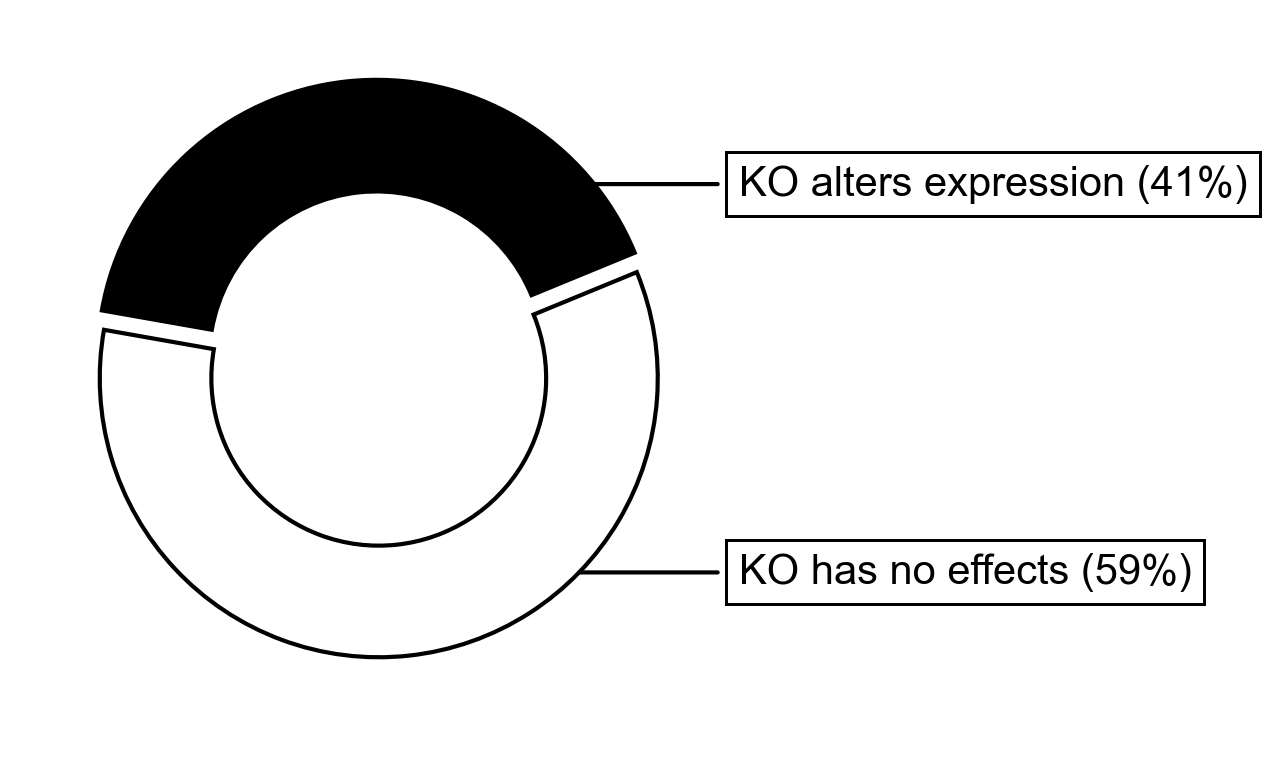

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6), dpi=300)#subplot_kw=dict(aspect="equal"))

p1 = p1.loc[p.columns,:]
p1_n = p1.shape[0]
p1_fx = (p1['energy_test_p_value'] < 1e-3).sum()
p1_f = p1_fx / p1_n
p1_med = p1.query('energy_test_p_value < 1e-3')['anderson_darling_counts'].median()

labels = ["KO has no effects ({0:.0f}%)".format(100*(1 - p1_f)), 
          "KO alters expression ({0:.0f}%)".format(100*p1_f)
         ]

data = [1 - p1_f, p1_f]

wedges, texts = ax.pie(data, 
                       wedgeprops=dict(width=0.4, 
                                       linewidth=1,
                                       edgecolor="black"), 
                       startangle=170, 
                       colors=['white','black'],
                       explode=[0, 0.07]
                    )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = 'left'
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], 
                xy=(x, y), 
                #xytext=(-0.3*np.sign(x), 1.4*y),
                xytext=(12*np.abs(x), 0.7*y),
                horizontalalignment=horizontalalignment, 
                **kw)
    
print(p1.query('energy_test_p_value < 1e-3')['anderson_darling_counts'].describe(), 
      p1['anderson_darling_counts'].describe(), p1_fx)

## Cycles

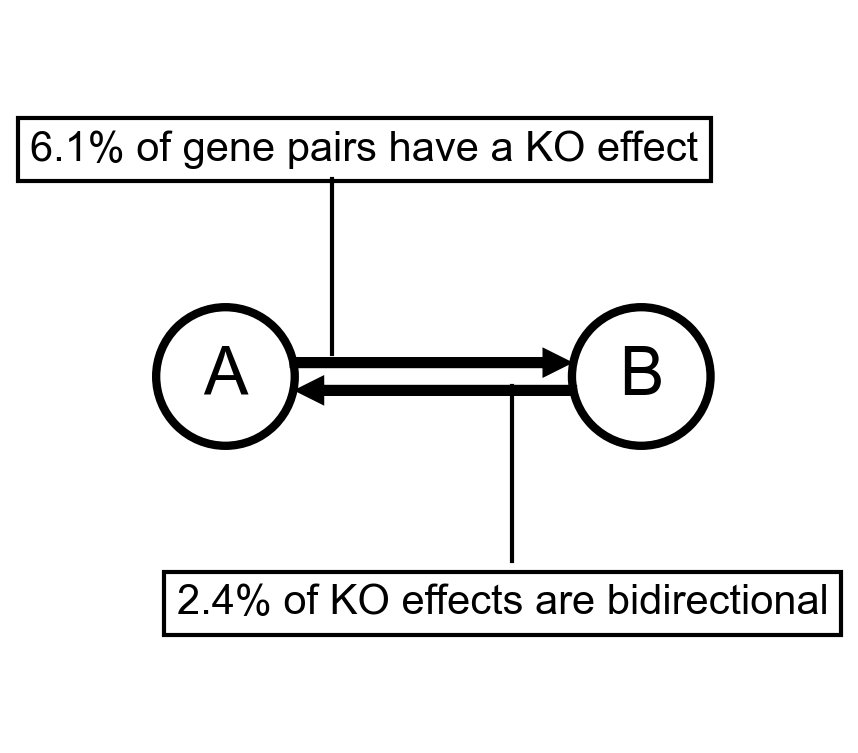

865719 20621 13762881.0


In [22]:
# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)

# Create nodes A and B as circles
r=0.1
circle_a = plt.Circle((0.2, 0.5), r, facecolor='white', edgecolor='black', linewidth=2)
circle_b = plt.Circle((0.8, 0.5), r, facecolor='white', edgecolor='black', linewidth=2)

# Add the circles to the plot
ax.add_patch(circle_a)
ax.add_patch(circle_b)
ax.text(0.2, 0.5, 'A', ha='center', va='center', color='black', fontsize=16)
ax.text(0.8, 0.5, 'B', ha='center', va='center', color='black', fontsize=16)

# Add arrows
hw,hl=0.02,0.02
arrow_ab = plt.arrow(0.2+r, 0.5+hw,  0.6-hl-(2*r)-0.015, 0, 
                     color='black', 
                     linewidth=2.5,
                     head_width=hw, 
                     head_length=hl)
arrow_ba = plt.arrow(0.8-r, 0.5-hw, -0.6+hl+(2*r)+0.015, 0, 
                     color='black', 
                     linewidth=2.5,
                     head_width=hw, 
                     head_length=hl)

# Add text boxes with labels

nc2 = scipy.special.comb(R.number_of_nodes(), 2)
m = int(R.number_of_edges())
mm = int(sum([(b,a) in R.edges for (a,b) in R.edges])/2)
#t = nx.triangles(nx.Graph(R))
#tri = sum(t.values())

text_box_ab = ax.text(0.4, 0.8, 
                      '{:.1f}% of gene pairs have a KO effect'.format(100*(m-mm)/nc2), 
                      ha='center', va='bottom', 
                      bbox=dict(boxstyle='square', facecolor='white', edgecolor='black'))
text_box_ba = ax.text(0.6, 0.2, 
                      '{:.1f}% of KO effects are bidirectional'.format(100*mm/(m-mm)), 
                      ha='center', va='top', 
                      bbox=dict(boxstyle='square', facecolor='white', edgecolor='black'))

# Draw lines connecting text boxes to arrows
line_ab = lines.Line2D([0.4, 0.4], [0.5+hw, 0.715], 
                       linewidth=1, 
                       color='black', 
                       transform=fig.transFigure, figure=fig)
line_ba = lines.Line2D([0.6, 0.6], [0.29, 0.5-hw+0.005], 
                       color='black', 
                       linewidth=1,
                       transform=fig.transFigure, 
                       figure=fig)
fig.lines.extend([line_ab, line_ba])

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)

# Set aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

print(m, mm, nc2)

## Degree distribution

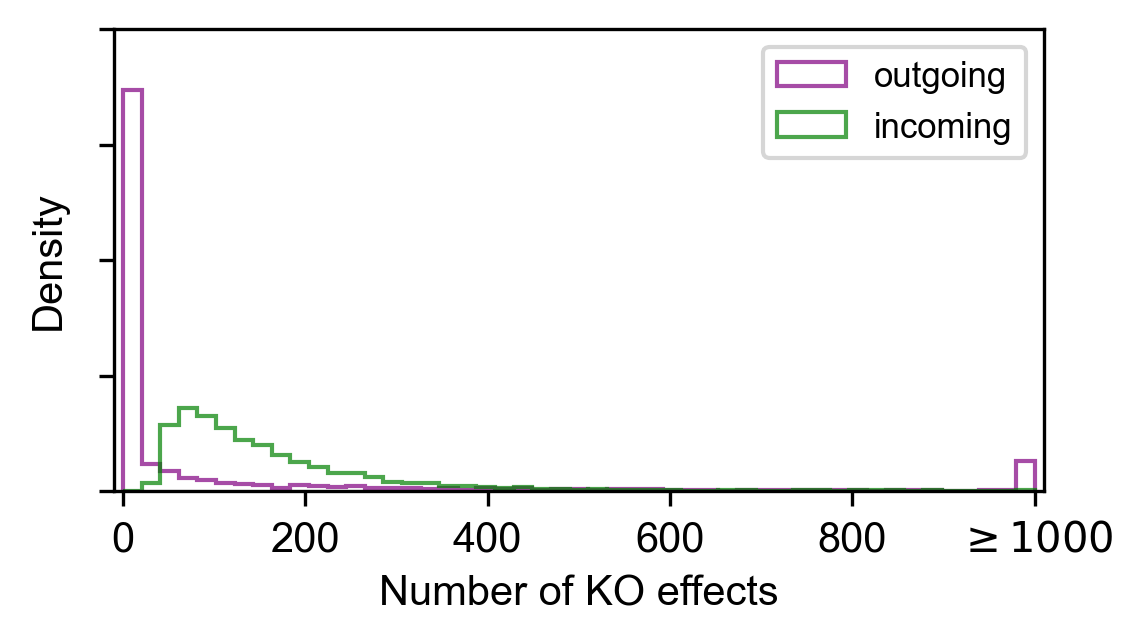

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4,2), dpi=300)

out_ko = np.sum(p < 5e-2, axis=0)
inc_ko = np.sum(p < 5e-2, axis=1)

xm=1000

plt.hist(out_ko.clip(0, xm), 
         bins=np.linspace(0, xm, 50),
         histtype='step', 
         #cumulative=-1,
         alpha=0.7,
         color='purple',
         label='outgoing');# (median {})'.format(np.median(out_ko)));

plt.hist(inc_ko.clip(0, xm), 
         bins=np.linspace(0, xm, 50),
         histtype='step',
         #cumulative=-1,
         alpha=0.7,
         color='green',
         label='incoming');# (median {})'.format(np.median(inc_ko)));

plt.xlim(-10, xm+10);
plt.legend(fontsize='small');
ax.set_xlabel('Number of KO effects'); 
ax.set_ylabel('Density');
#ax.semilogy(); ax.set_ylabel('log density');
ax.set_yticks(ax.get_yticks()); ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);
ax.set_xticks([0,200,400,600,800,1000]); ax.set_xticklabels(['0','200','400','600','800',r'$\geq1000$']);
#ax.set_xticklabels([text.get_text().replace(str(xm), r'$\geq$'+str(xm)) for text in ax.get_xticklabels()]);
#ax.axvline(np.median(out_ko), linewidth=0.5, linestyle='solid', color='purple', alpha=0.4);
#ax.axvline(np.median(inc_ko), linewidth=0.5, linestyle='solid', color='green', alpha=0.4);

/tmp/ipykernel_28202/3754356639.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);


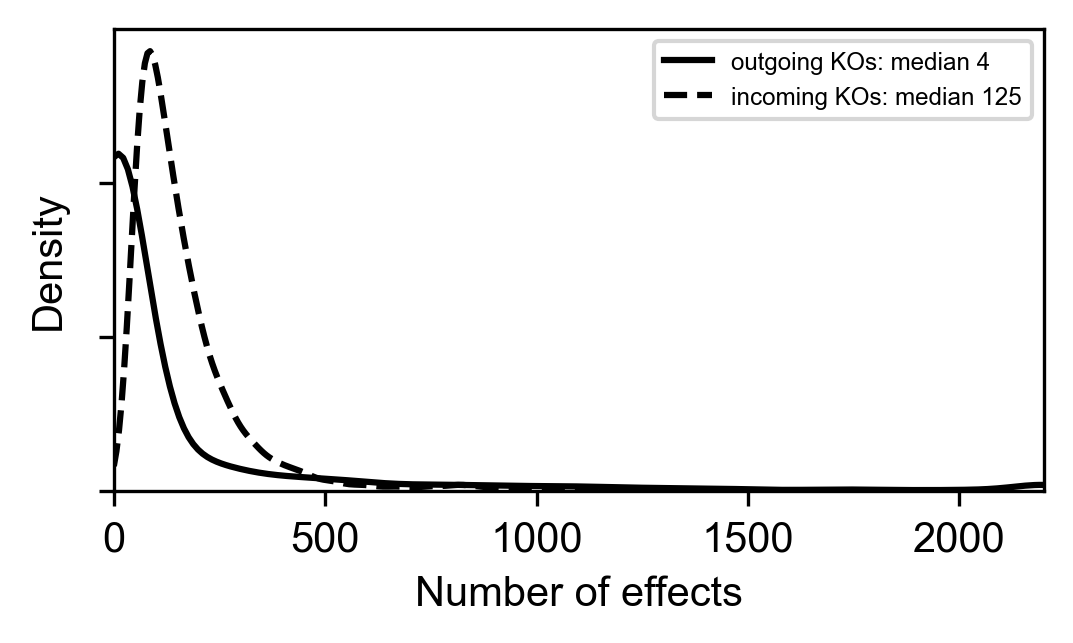

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4,2), dpi=300)

xm=2200

out_ko = np.sum(p < 5e-2, axis=0)
inc_ko = np.sum(p < 5e-2, axis=1)

sns.kdeplot(out_ko.clip(0, xm), 
            clip=(0,xm), 
            #cumulative=1,
            ax=ax, 
            color='k',
            label="outgoing KOs: median {:.0f}".format(np.median(out_ko)))
sns.kdeplot(inc_ko.clip(0, xm), 
            clip=(0,xm), 
            #cumulative=1,
            ax=ax, 
            color='k', linestyle='dashed',
            label='incoming KOs: median {:.0f}'.format(np.median(inc_ko)))

plt.xlim(0, xm);
plt.legend(fontsize='xx-small');
ax.set_xlabel('Number of effects'); 
ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);

## Effects of baseline expression

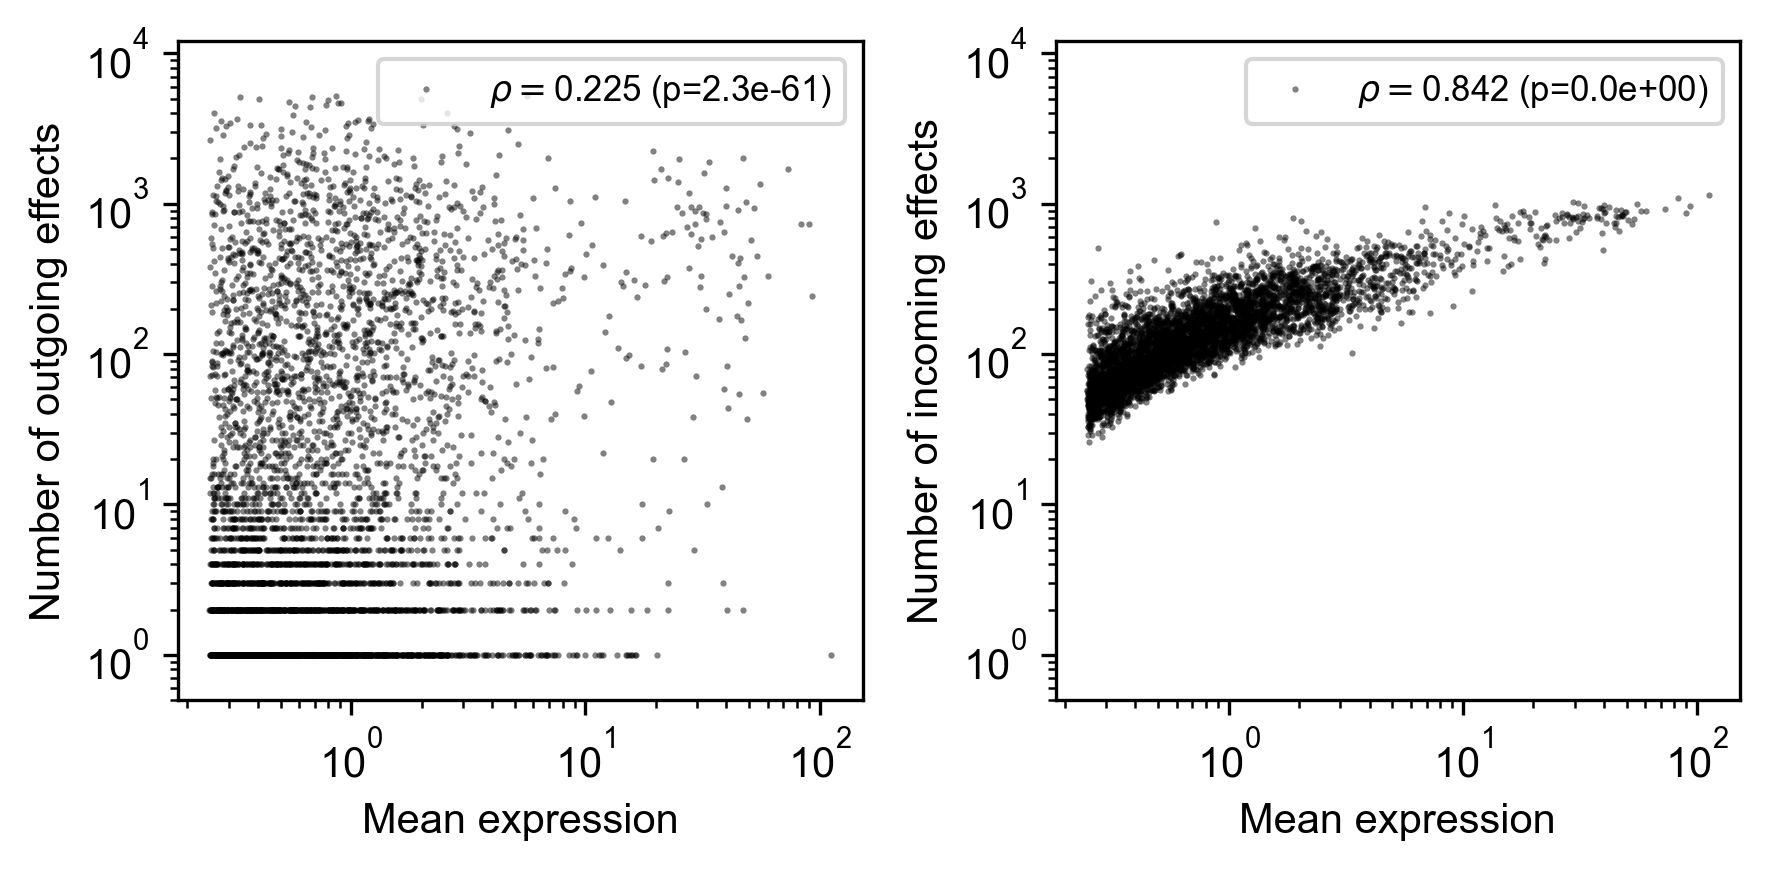

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)

for i,name in enumerate(['outgoing', 'incoming']):
    x=bulk.var.loc[p.index, 'mean']
    y=np.sum(p < 5e-2, axis=i)
    
    ax[i].plot(x, y, 'k.', ms=1, alpha=0.5)
    ax[i].loglog();
    ax[i].set_xlabel('Mean expression')
    ax[i].set_ylabel('Number of {} effects'.format(name))
    ax[i].set_ylim(0.5, 12e3)
    ax[i].legend([r'$\rho=$'+'{0:.3f} (p={1:.1e})'.format(*scipy.stats.spearmanr(x, y))], fontsize='small')

fig.tight_layout();

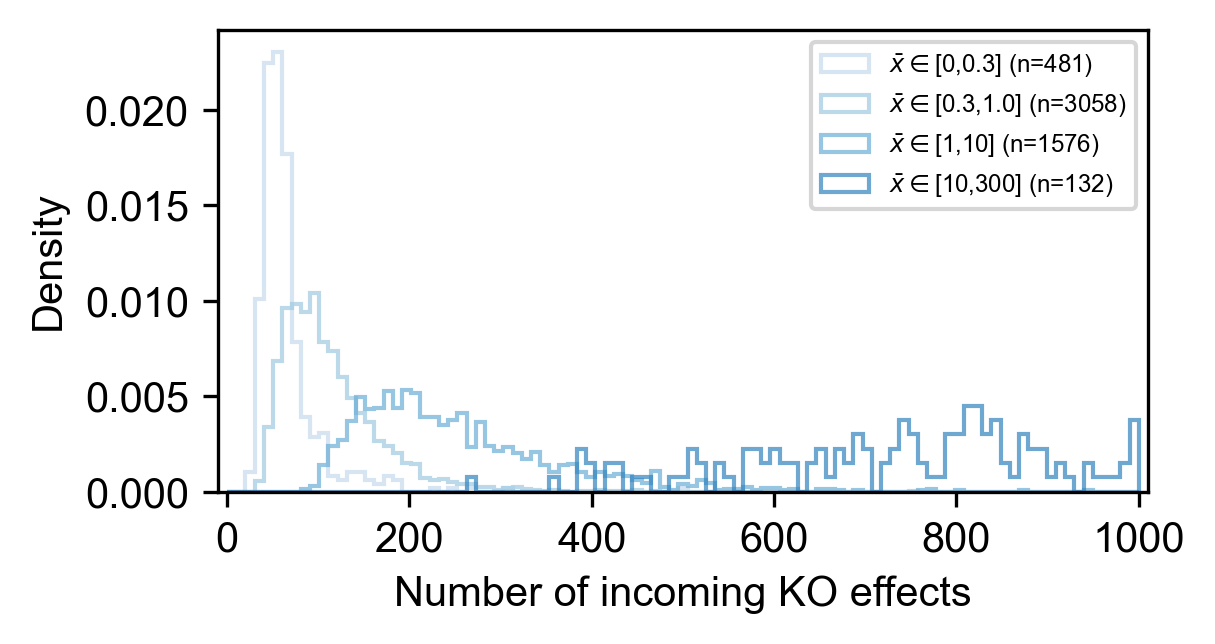

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4,2), dpi=300)

xm=1000
for i,(a,b) in enumerate([(0,0.3), (0.3,1.0), (1, 10), (10, 300)]):
    subset=bulk.var.query('@a <= clean_mean & clean_mean < @b').index.intersection(p.index)
    plt.hist(np.sum(p < 5e-2, axis=1).loc[subset].clip(0, xm), 
             bins=np.linspace(0, xm, 100),
             histtype='step',
             #cumulative=-1,
             density=True,
             alpha=0.7,
             color=plt.get_cmap('tab20c').colors[3-i],
             label='{0}[{1},{2}] (n={3})'.format(r'$\bar{x}\in$',a,b,subset.shape[0]));

plt.xlim(-10, xm+10);
plt.legend(fontsize='xx-small');
ax.set_xlabel('Number of incoming KO effects'); 
ax.set_ylabel('Density');
#ax.semilogy(); ax.set_ylabel('log density');
#ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);

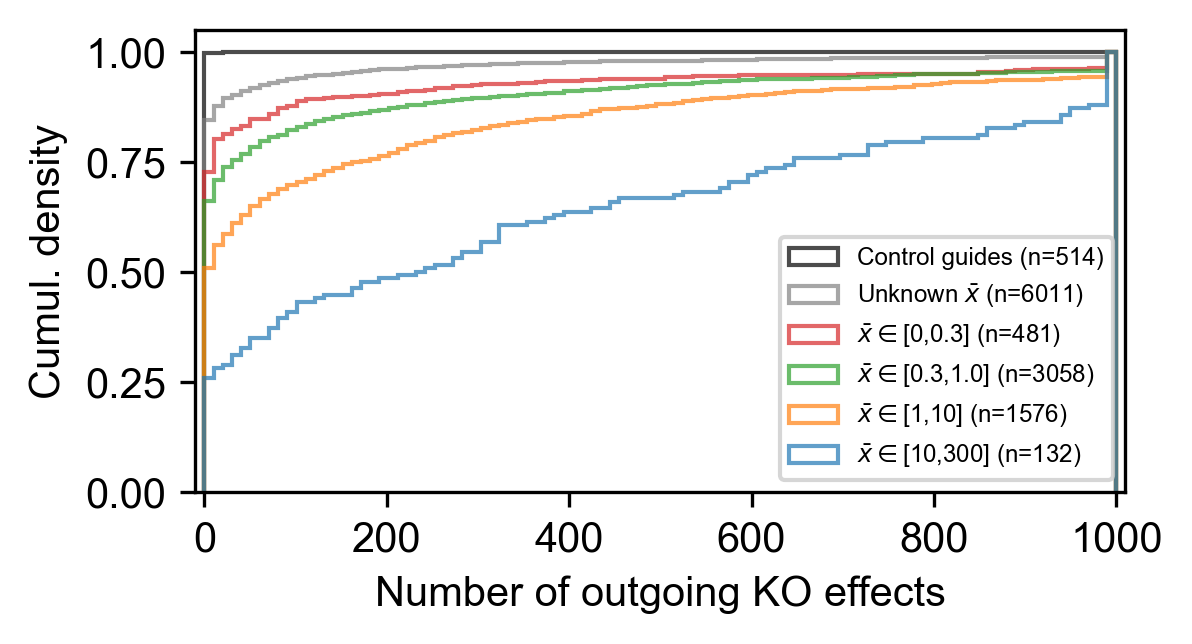

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4,2), dpi=300)

xm=1000
# these are actually piled up at zero, so we don't have to exclude any of the genes
plt.hist(bulk.obs.query('core_control')['anderson_darling_counts'].clip(0, xm),
         bins=np.linspace(0, xm, 100),
         histtype='step',
         cumulative=1,
         density=True,
         alpha=0.7, 
         color='k',
         label='Control guides (n={0})'.format(bulk.obs.core_control.sum()));

# also piled up at zero
plt.hist(bulk.obs.loc[bulk.obs.index.difference(p.columns), 'anderson_darling_counts'].clip(0, xm),
         bins=np.linspace(0, xm, 100),
         histtype='step',
         cumulative=1,
         density=True,
         alpha=0.7, 
         color='gray',
         label='Unknown {0} (n={1})'.format(r'$\bar{x}$', len(bulk.obs.index.difference(p.columns))));

for i,(a,b) in enumerate([(0,0.3), (0.3,1.0), (1, 10), (10, 300)]):
    subset=bulk.var.query('@a <= clean_mean & clean_mean < @b').index.intersection(p.index)
    plt.hist(np.sum(p < 5e-2, axis=0).iloc[p.index.isin(subset)].clip(0, xm), 
             bins=np.linspace(0, xm, 100),
             histtype='step',
             cumulative=1,
             density=True,
             alpha=0.7,
             color=plt.get_cmap('tab10').colors[3-i],
             label='{0}[{1},{2}] (n={3})'.format(r'$\bar{x}\in$',a,b,subset.shape[0]));

plt.xlim(-10, xm+10);
plt.legend(fontsize='xx-small', loc='lower right');
ax.set_xlabel('Number of outgoing KO effects'); 
ax.set_ylabel('Cumul. density');
#ax.semilogy(); ax.set_ylabel('log density');
#ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);

## Modules

**Functional analyses of strong perturbations**: We conducted functional analyses to gain insight into the types of gene perturbations that induced strong transcriptional phenotypes. ‘‘Strong’’ perturbations were defined by three criteria: (i) at least 50 differentially expressed genes at a significance of p < 0.05 by Anderson-Darling test following Benjamini-Hochberg correction; (ii) at least 25 cells that passed our quality filters; and (3) an on-target knockdown, if measured, of at least 30% (i.e. the target of perturbation was either knocked down by at least 30% or was not detected, a broad attempt to remove non-functional perturbations). ‘‘Weak’’ perturbations met the same criteria but had fewer than 5 differentially expressed genes. Strong and weak perturbations were largely similar in terms of representation and knockdown efficacy, as described in Figure S2. To look for classes of functional behaviors among strong and weak perturbations, we used the gseapy implementation of the Enrichr algorithm to compute gene set enrichment p-values within the KEGG2021 pathway gene set (with the set of all targeted genes in the experiment as the background list). To determine whether strong and weak perturbations fell in different subcellular locations, we used location annotations from Itzhak et al. (2016).

**Global analysis and clustering of strong perturbations** The analysis presented covers 1973 perturbations that met three criteria: (i) at least 50 differentially expressed genes at a significance of p < 0.05 by Anderson-Darling test following Benjamini-Hochberg correction; (ii) at least 25 cells that passed our quality filters; and (3) an on-target knockdown, if measured, of at least 30% (i.e. the target of perturbation was either knocked down by at least 30% or was not detected, a broad attempt to remove non-functional perturbations). As features, we used a union of two sets of genes: (i) the top 10 differentially expressed genes for all perturbations (ordered by the value of the Anderson-Darling test statistic) and (ii) all genes of mean >0.25 UMIs per cell with variance in the top 30% of the dataset. We represented perturbations by their mean normalized expression profile across these 2319 highly variable genes. To prevent the direct targets of knockdown influencing results, the target gene value was replaced by 0 for the corresponding perturbation. For example, RPS5 gene normalized expression was set to 0 in the expression profile of the RPS5 perturbation, which is equal to the mean in control cells by construction.

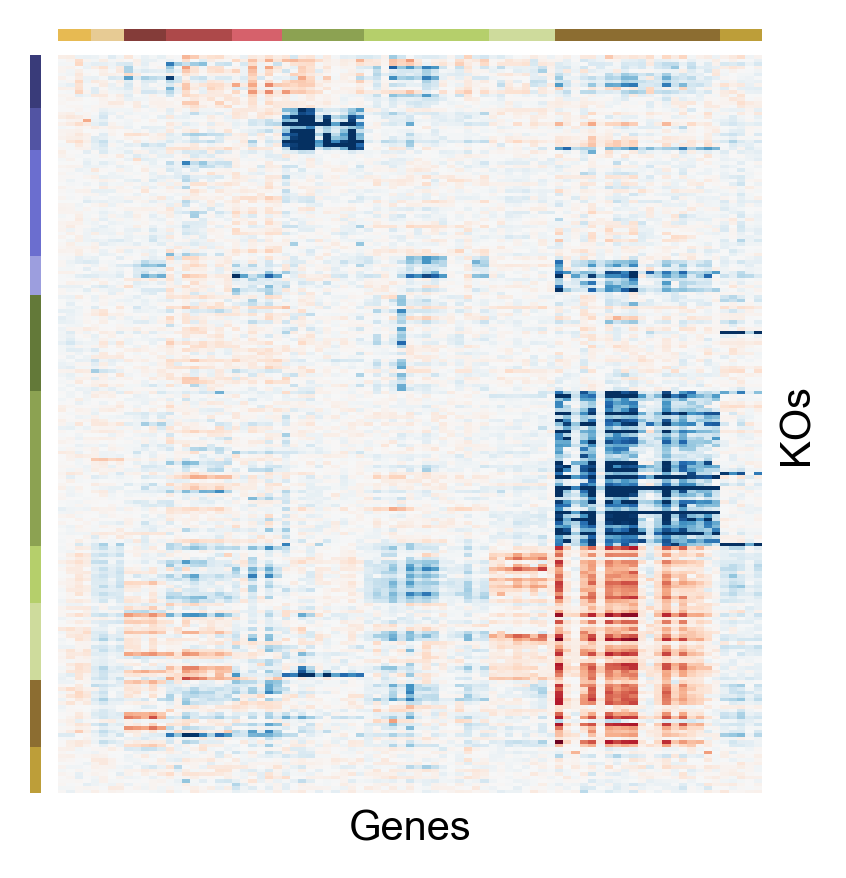

In [31]:
df = means.loc[(slice(None), range(0,10)), 
               (slice(None), map(str,range(5,15)))
              ].fillna(0).T.sort_values('cluster').T

cm = dict(enumerate(plt.get_cmap('tab20b').colors))

cg = sns.clustermap(df, 
                    row_cluster=False, 
                    col_cluster=False, 
                    row_colors=[cm.get(int(s) % 20) for s in df.index.get_level_values('cluster')], 
                    col_colors=[cm.get(int(s) % 20) for s in df.columns.get_level_values('cluster')],
                    colors_ratio=0.015,
                    cbar_pos=None, dendrogram_ratio=0,
                    cmap='RdBu', vmin=-2, vmax=2, center=0, figsize=(4,6)
                    )

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

cg.ax_heatmap.set_xticks([]);
cg.ax_heatmap.set_yticks([]);
cg.ax_heatmap.set_ylabel('KOs');
cg.ax_heatmap.set_xlabel('Genes');
#cg.fig.tight_layout();
cg.figure.set_dpi(300); 
#cg.figure.savefig('test.png',dpi=300);
#cg.figure.set_size_inches(3,5);

#plt.xticks([]); plt.yticks([]);
#plt.xlabel('Genes'); plt.ylabel('KOs');

gene_transcript   7883_SH3GL1_P1P2_ENSG00000141985  \
cluster                                          0   
gene_name cluster                                    
MT-ND6    0                              -0.093562   
MT-CO2    0                              -0.093562   
MT-CYB    0                              -0.093562   
MT-ND2    0                              -0.093562   
MT-ND5    0                              -0.093562   

gene_transcript   7033_RAB4B_P1P2_ENSG00000167578  \
cluster                                         0   
gene_name cluster                                   
MT-ND6    0                             -0.093562   
MT-CO2    0                             -0.093562   
MT-CYB    0                             -0.093562   
MT-ND2    0                             -0.093562   
MT-ND5    0                             -0.093562   

gene_transcript   7341_RNF11_P1P2_ENSG00000123091  \
cluster                                         0   
gene_name cluster                   

/share/software/user/open/py-scanpy/1.8.2_py39/lib/python3.9/site-packages/seaborn/matrix.py:1197: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


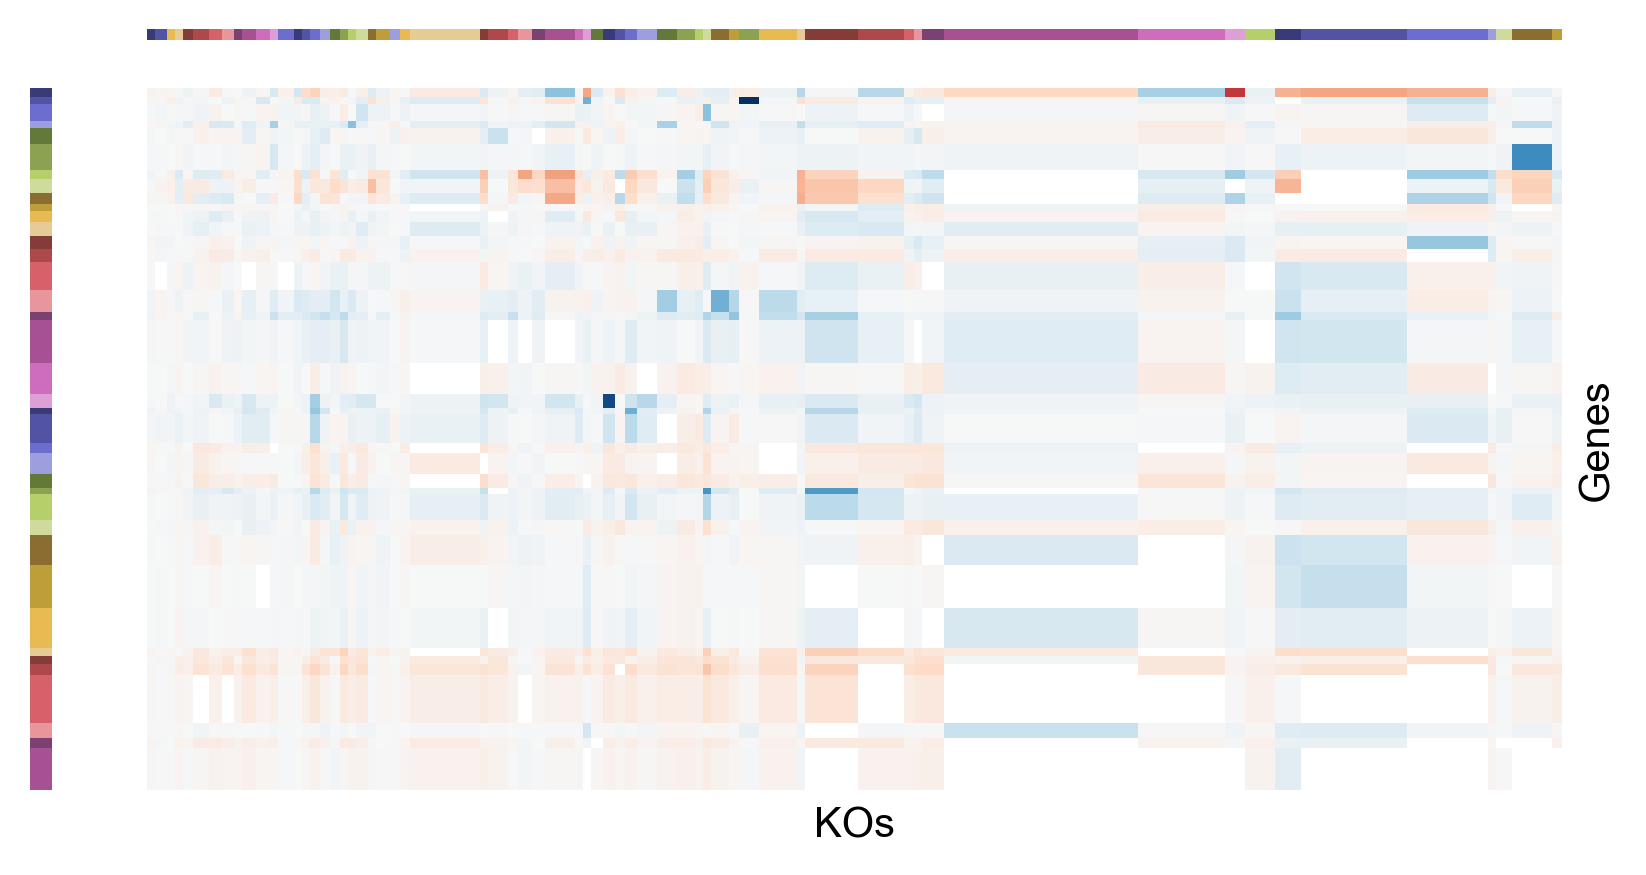

In [32]:
df2 = means.loc[(slice(None), range(0,38)), 
                (slice(None), map(str,range(0,64)))
               ].fillna(0).T.sort_values('cluster').T

for i in means.index.get_level_values('cluster').unique():
    for j in means.columns.get_level_values('cluster').unique():
        if int(i) < 0 or int(j) < 0: 
            continue
        x, y = (slice(None),i), (slice(None),j)
        df2.loc[x,y] = np.mean(means.loc[x,y].values)

print(df2.iloc[:5,:5])        

cg = sns.clustermap(df2, 
                    row_cluster=False, 
                    col_cluster=False, 
                    row_colors=[cm.get(int(s) % 20) for s in df2.index.get_level_values('cluster')], 
                    col_colors=[cm.get(int(s) % 20) for s in df2.columns.get_level_values('cluster')],
                    colors_ratio=0.015,
                    cbar_pos=None, dendrogram_ratio=0,
                    cmap='RdBu', vmin=-2, vmax=2, center=0, figsize=(7,3.5)
                    )

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

cg.ax_heatmap.set_xticks([]);
cg.ax_heatmap.set_yticks([]);
cg.ax_heatmap.set_ylabel('Genes');
cg.ax_heatmap.set_xlabel('KOs');
cg.figure.set_dpi(300); 

In [33]:
# starts with kos
n_ko = 13

# find modules with strongest affinities for each other -- get the modules by looking at kos
mods_ko = df2.abs().max(axis=0).sort_values(ascending=False).drop_duplicates()
display(mods_ko[:n_ko])

# identify the kos
m_ko = mods_ko.index.get_level_values('cluster')[:n_ko]

# and now the genes 
mods_tg = df2.abs().loc[:, (slice(None), m_ko)
                       ].max(axis=1).sort_values(ascending=False).drop_duplicates()
ix = np.where(mods_tg >= mods_ko[n_ko-1])[0][-1]
display(mods_tg[:(ix+1)])

m_tg = mods_tg.index.get_level_values('cluster')[:(ix+1)]

# starts with genes
"""
n_tg = 13

# find modules with strongest affinities for each other -- get the values
mods_tg = df2.abs().max(axis=1).sort_values(ascending=False).drop_duplicates()
display(mods_tg[:n_tg])

# now the gene clusters
m_tg = mods_tg.index.get_level_values('cluster')[:n_tg]

# finally the ko clusters
mods_ko = df2.abs().loc[(slice(None), m_tg), :
                       ].max(axis=0).sort_values(ascending=False).drop_duplicates()
ix = np.where(mods_ko >= mods_tg[n_tg-1])[0][-1]
display(mods_ko[:(ix+1)])

m_ko = mods_ko.index.get_level_values('cluster')[:(ix+1)]
"""

gene_transcript                        cluster
8168_SMG7_P1P2_ENSG00000116698         5          2.625195
1588_CHMP6_P1P2_ENSG00000176108        40         1.804583
6499_PNPT1_P1P2_ENSG00000138035        59         1.420373
2793_EXOSC6_P1P2_ENSG00000223496       8          1.251091
8157_SMC3_P1P2_ENSG00000108055         47         1.178274
127_ADAM10_P1P2_ENSG00000137845        52         1.130266
3818_HMBOX1_P1P2_ENSG00000147421       42         0.981734
2551_EIF3G_P1P2_ENSG00000130811        39         0.964445
2251_DMAP1_P1P2_ENSG00000178028        48         0.962104
1842_CPSF3_P1P2_ENSG00000119203        26         0.836529
8670_TAF8_P1P2_ENSG00000137413         37         0.821607
10746_AC118549.1_P1P2_ENSG00000036549  35         0.811928
812_BCR_P1P2_ENSG00000186716           49         0.791382
dtype: float64

gene_name  cluster
TAF1D      1          2.625195
TUBB2B     19         1.804583
MT-CO2     0          1.420373
H1FX       5          1.251091
UQCRB      25         1.178274
LRP10      20         0.981734
FAM178B    15         0.962104
HIST1H2AC  3          0.836529
SEC61B     2          0.827988
RPS3A      6          0.821607
GYPE       16         0.791382
dtype: float64

"\nn_tg = 13\n\n# find modules with strongest affinities for each other -- get the values\nmods_tg = df2.abs().max(axis=1).sort_values(ascending=False).drop_duplicates()\ndisplay(mods_tg[:n_tg])\n\n# now the gene clusters\nm_tg = mods_tg.index.get_level_values('cluster')[:n_tg]\n\n# finally the ko clusters\nmods_ko = df2.abs().loc[(slice(None), m_tg), :\n                       ].max(axis=0).sort_values(ascending=False).drop_duplicates()\nix = np.where(mods_ko >= mods_tg[n_tg-1])[0][-1]\ndisplay(mods_ko[:(ix+1)])\n\nm_ko = mods_ko.index.get_level_values('cluster')[:(ix+1)]\n"

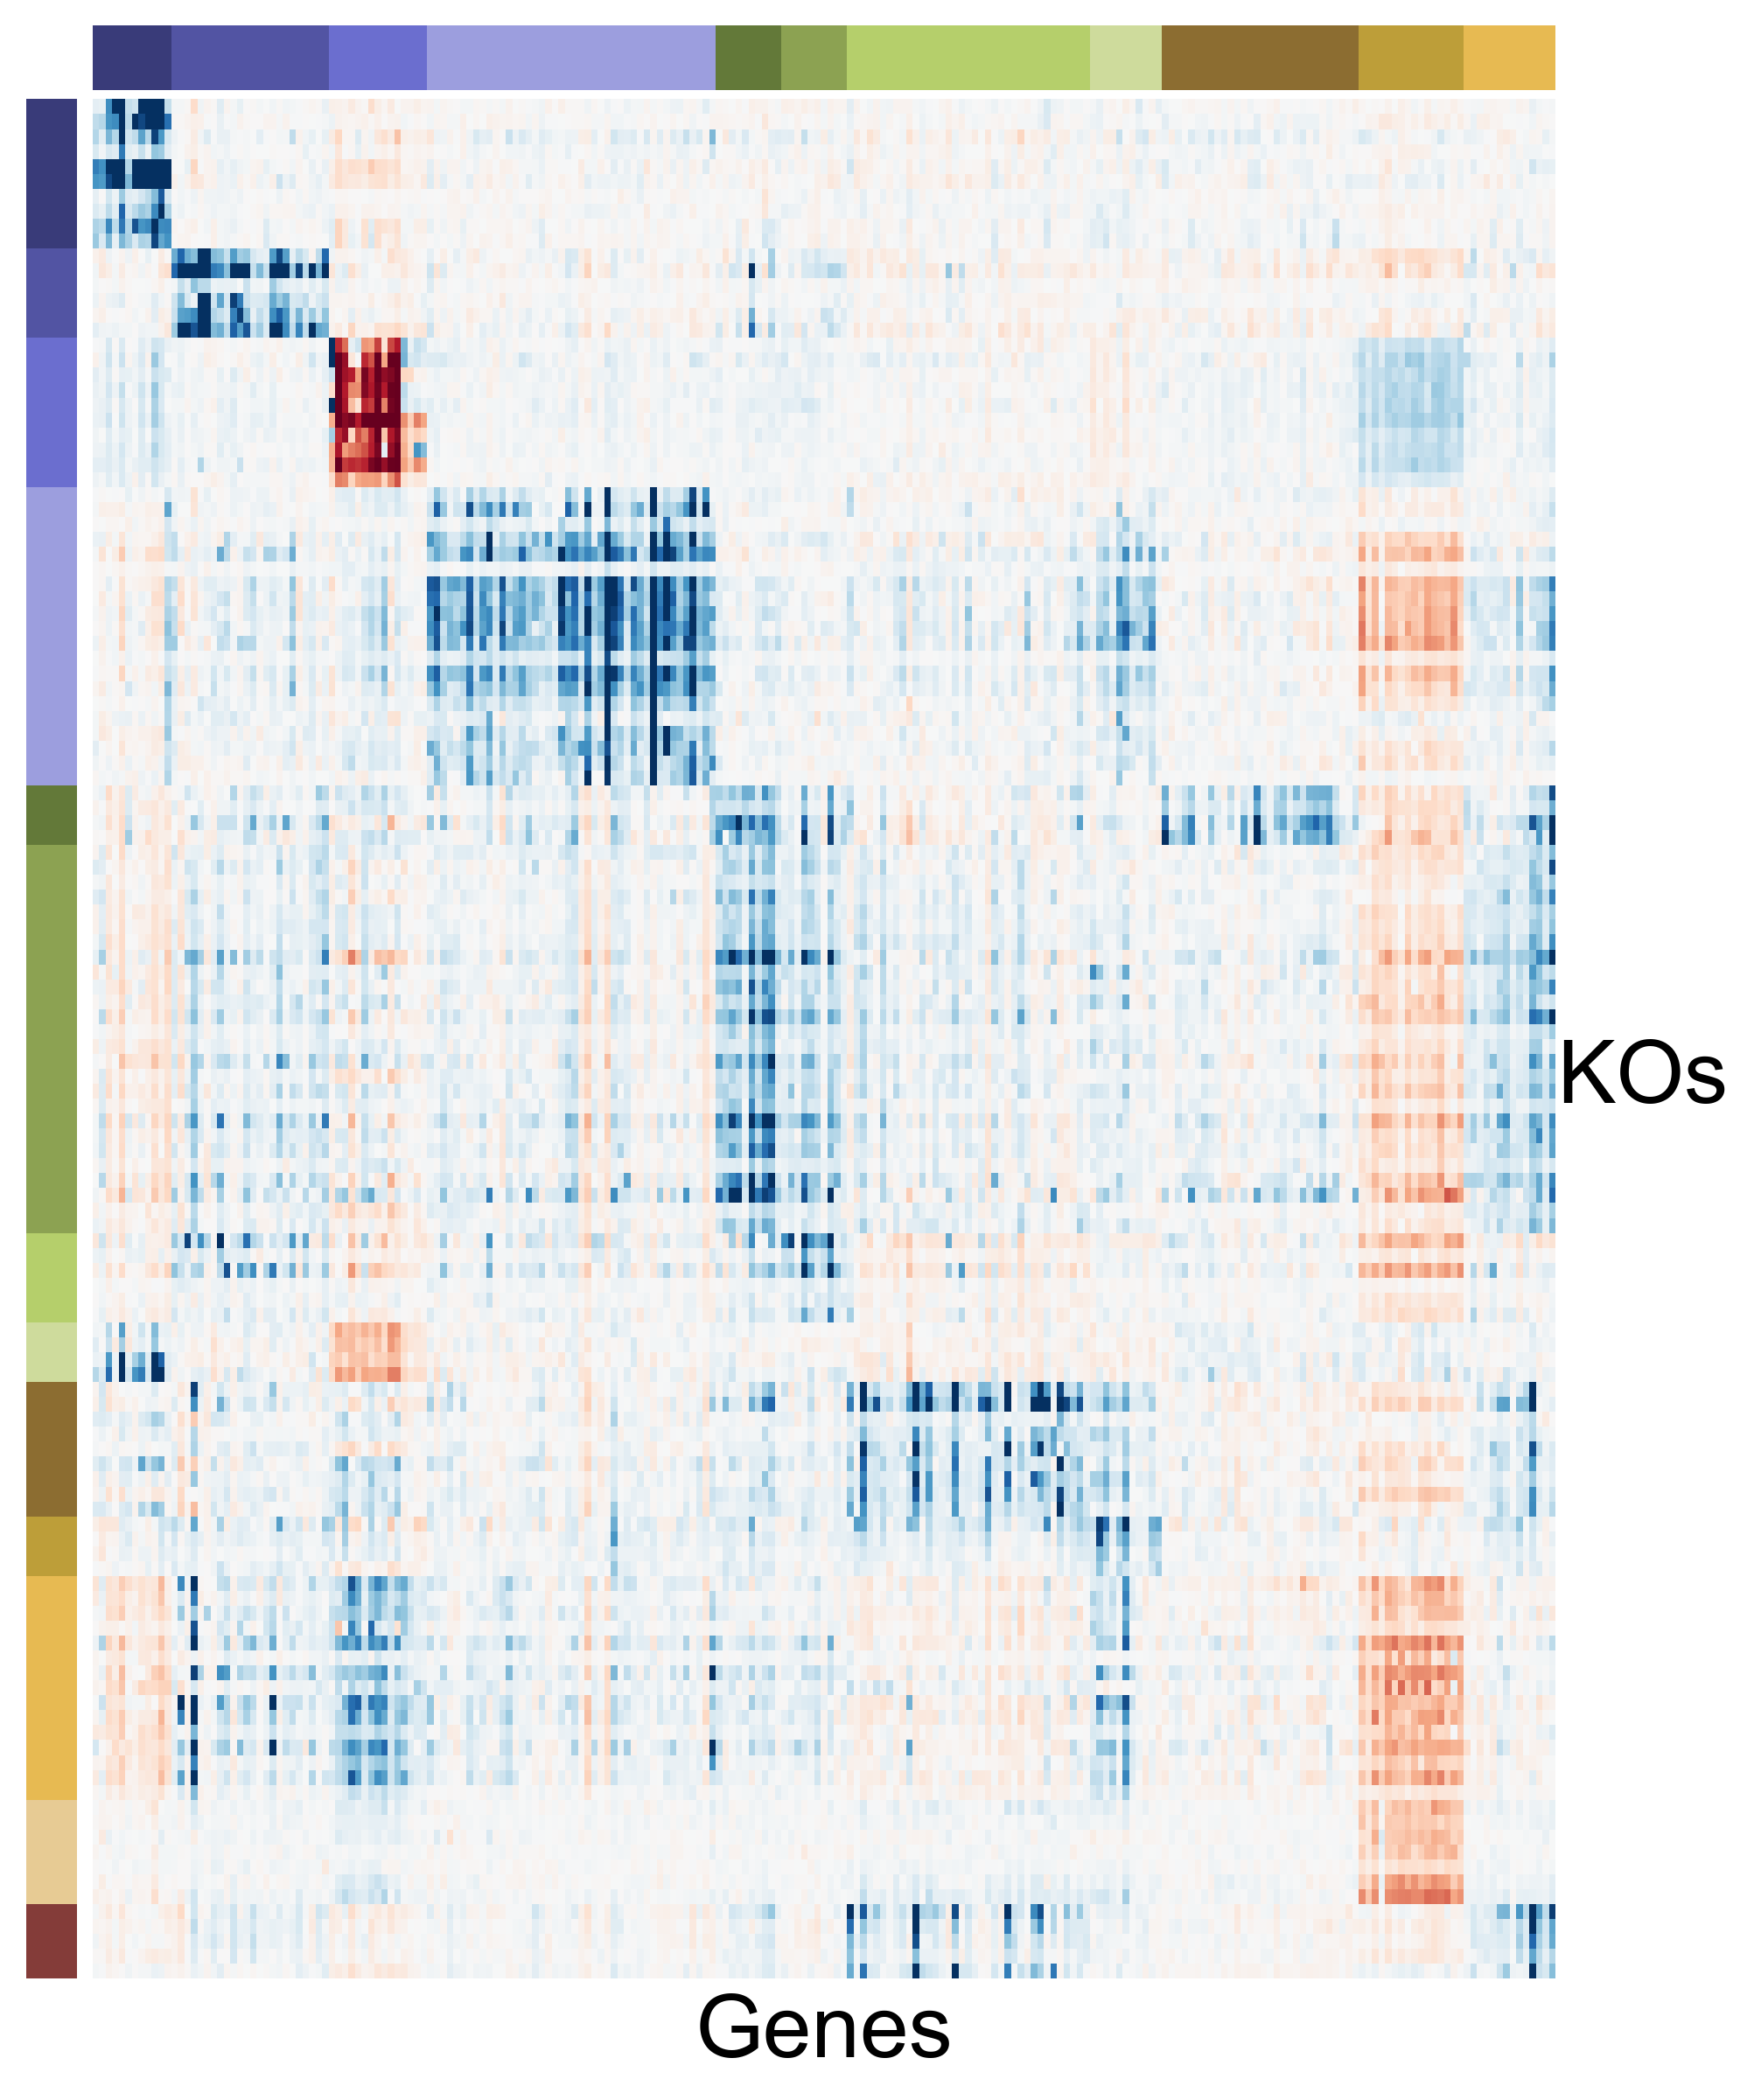

In [34]:
rows = list(m_tg)
cols = list(m_ko)
subset = means.loc[(slice(None), rows), (slice(None), cols)].T

cm = dict(enumerate(plt.get_cmap('tab20b').colors))
cg = sns.clustermap(subset, 
                    row_cluster=False, 
                    col_cluster=False, 
                    row_colors=[cm.get(cols.index(s)) for s in subset.index.get_level_values('cluster')], 
                    col_colors=[cm.get(rows.index(s)) for s in subset.columns.get_level_values('cluster')],
                    #colors_ratio=0.015,
                    cbar_pos=None, 
                    dendrogram_ratio=0.1,
                    cmap='RdBu', vmin=-3, vmax=3, center=0, 
                    #cmap='binary', vmin=0, vmax=2,
                    #figsize=(7,2)
                    )

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

cg.ax_heatmap.set_xticks([]);
cg.ax_heatmap.set_yticks([]);
cg.ax_heatmap.set_xlabel('Genes', fontsize=24);
cg.ax_heatmap.set_ylabel('      KOs', fontsize=24, rotation=0);
#cg.fig.tight_layout();
cg.figure.set_dpi(300); 

In [35]:
means.loc[(slice(None), rows[0]), (slice(None), cols[0])]

,gene_transcript,1198_CASC3_P1P2_ENSG00000108349,1670_CLOCK_P1P2_ENSG00000134852,4161_IPO13_P1P2_ENSG00000117408,4778_MAGOH_P1P2_ENSG00000162385,8166_SMG5_P1P2_ENSG00000198952,8168_SMG7_P1P2_ENSG00000116698,8169_SMG8_P1P2_ENSG00000167447,8170_SMG9_P1P2_ENSG00000105771,9600_UPF1_P1P2_ENSG00000005007,9601_UPF2_P1P2_ENSG00000151461
,cluster,5,5,5,5,5,5,5,5,5,5
gene_name,cluster,,,,,,,,,,
LETMD1,1,0.290579,0.762620,0.889198,0.485432,2.065807,1.763394,0.275148,0.433347,0.922048,1.118416
CIRBP,1,0.243811,0.855253,0.329420,0.104137,1.811184,1.695612,-0.011568,0.257014,0.815668,0.463513
CCNB1IP1,1,1.857937,1.770918,1.371750,0.503226,3.433365,2.701555,0.570592,0.783216,1.939834,1.352800
TAF1D,1,3.859755,1.888540,0.887868,0.374376,5.341546,2.981826,0.176165,0.343404,0.780182,0.266317
ZFAS1,1,13.802841,4.969703,4.674303,2.125434,13.877199,6.137557,1.092230,2.392866,2.168471,1.357829
SELENOW,1,0.713537,0.781658,0.599918,0.348001,0.875091,1.352742,0.372704,0.508568,0.883370,0.948598
SNHG12,1,0.623195,7.855975,0.772260,0.230143,35.178211,4.481257,0.258807,0.814361,2.618331,0.460452
SNHG32,1,4.868573,2.728902,1.600868,0.684550,7.256414,4.652907,0.543438,1.111876,1.766491,0.957644


In [36]:
module1 = means.loc[(slice(None), rows[1]), (slice(None), cols[1])]
m1genes = module1.index.get_level_values('gene_name').tolist()
m1kos = module1.columns.get_level_values('gene_transcript')
m1outs = bulk.var.loc[bulk.var['gene_name'].isin(m1genes),:].index

m1pvals = pvalues.loc[m1outs, m1kos].rename({c:c.split('_')[-1] for c in pvalues.columns}, axis=1).T

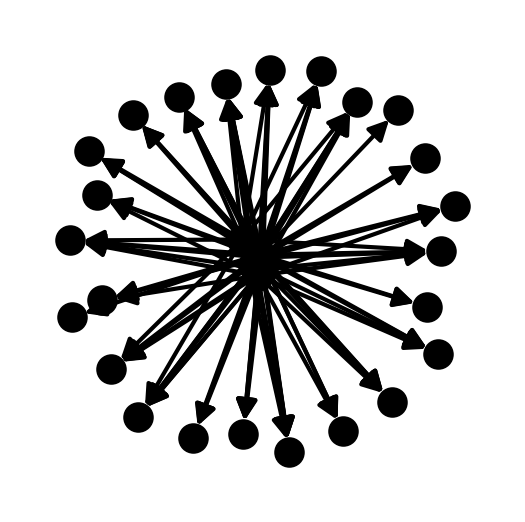

In [37]:
M = nx.from_edgelist([(m1pvals.index[i],m1pvals.columns[j]) for i,j in zip(*np.where(m1pvals < 5e-2))],
                     create_using=nx.DiGraph)

fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300)

pos = nx.spring_layout(M)
                     
nx.draw(M, pos, ax, 
        width = 1,
        edge_color = 'k', 
        node_color='k',
        node_size=40, 
        node_shape='o')
        #style=['-:'[(i < len(G)/2) != (j < len(G)/2)] for i,j in G.edges],
        #node_color = ['kb'[i >= len(G)/2] for i in G.nodes], node_size=40, node_shape='o')

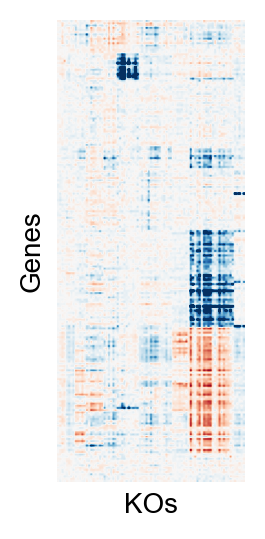

In [38]:
plt.figure(figsize=(5,3), dpi=200)

plt.imshow(df, cmap='RdBu', vmin=-2, vmax=2)
#plt.imshow(df.abs(), cmap='binary', vmin=0, vmax=2.5)

plt.xticks([]); plt.yticks([]);
plt.ylabel('Genes'); plt.xlabel('KOs');
plt.gca().set_frame_on(False)

# Drawings

## Sparsity

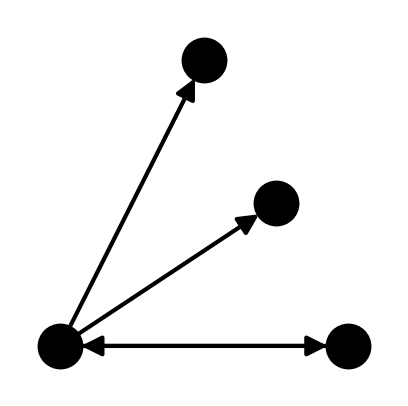

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)

#G = nx.fast_gnp_random_graph(5, 0.3, seed=None, directed=True)
G = nx.from_numpy_matrix(np.array([[0,1,1,1],
                                   [1,0,0,0],
                                   [0,0,0,0],
                                   [0,0,0,0]]),
                         create_using=nx.DiGraph())
pos = nx.planar_layout(G)
                     
nx.draw(G, pos, ax, 
        width = 1,
        edge_color = 'k', style='-',
        node_color='k', node_size=100, node_shape='o')

## Modularity

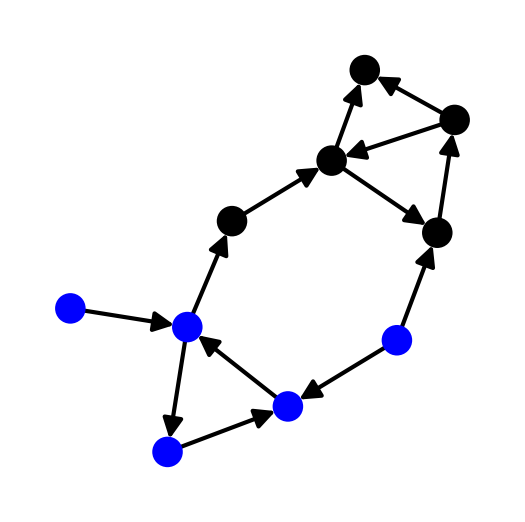

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300)

G = nx.stochastic_block_model([5,5], p=[[0.3,0.03],[0.03,0.3]], 
                              nodelist = None, seed=2012,
                              directed=True, selfloops=False, sparse=False)

pos = nx.kamada_kawai_layout(G)
                     
nx.draw(G, pos, ax, 
        width = 1,
        edge_color = 'k', 
        style='-',#['-:'[(i < len(G)/2) != (j < len(G)/2)] for i,j in G.edges],
        node_color = ['kb'[i >= len(G)/2] for i in G.nodes], node_size=40, node_shape='o')

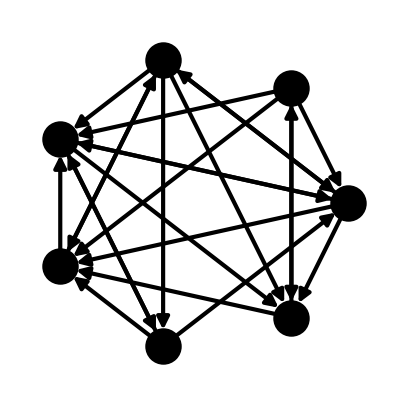

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)

nx.draw_circular(nx.erdos_renyi_graph(7, 0.5, directed=True), 
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color='k', node_size=60, node_shape='o'); 

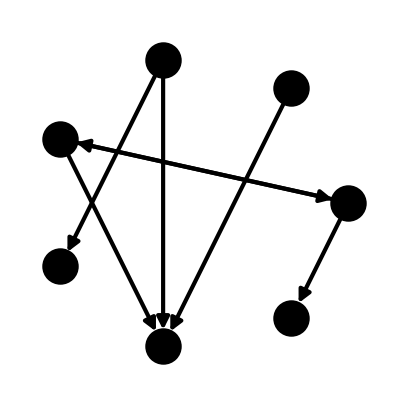

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)

nx.draw_circular(nx.erdos_renyi_graph(7, 0.1, directed=True, seed=94019), 
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color='k', node_size=60, node_shape='o', with_labels=0); 

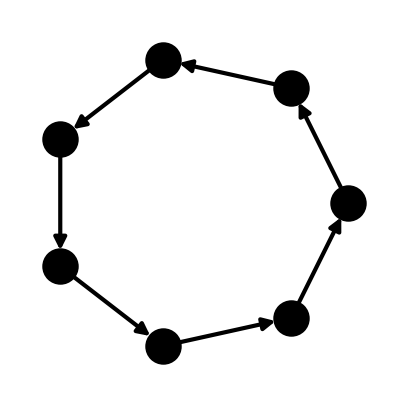

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)
nx.draw_circular(nx.cycle_graph(7, create_using=nx.DiGraph), 
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color='k', node_size=60, node_shape='o'); 

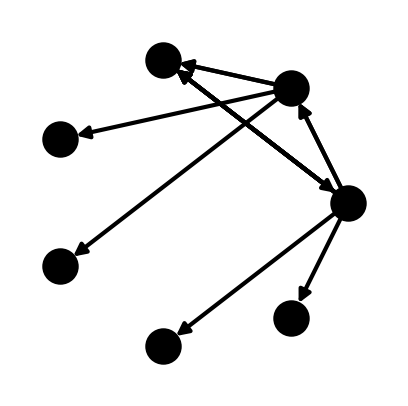

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)

G = nx.generators.directed.scale_free_graph(7, alpha=0.01, beta=0.75, gamma=0.24, delta_in=5, delta_out=0.1, seed=94305)
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw_circular(G,
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color='k', node_size=60, node_shape='o', with_labels=1, labels={i:'' if i<2 else '' for i in range(7)}); 

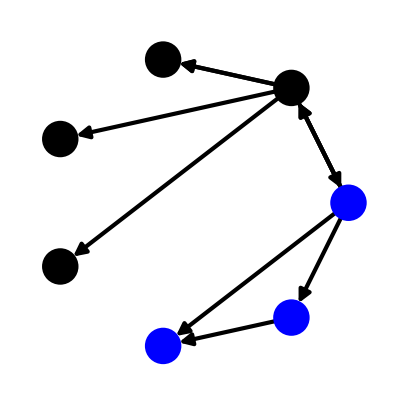

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5), dpi=300)

H = G.copy()
while (0,2) in H.edges() or (2,0) in H.edges():
    H.remove_edges_from([(2,0),(0,2)])
H.add_edges_from([(1,0),(6,5)])

nx.draw_circular(H,
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color=['bk'[i in range(1,5)] for i in G.nodes], node_size=60, node_shape='o'); 

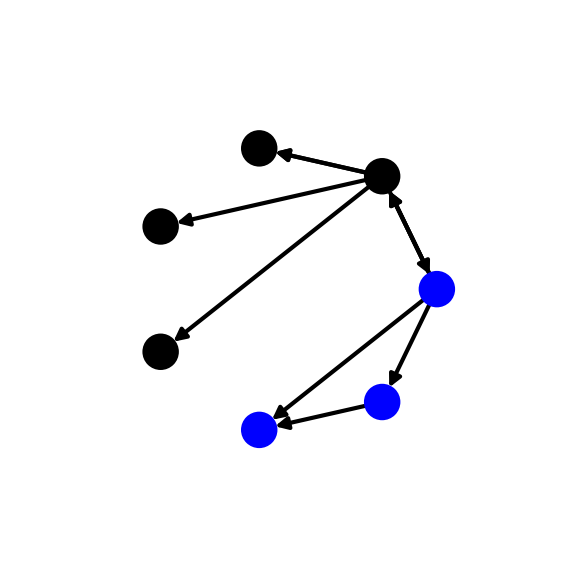

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25), dpi=300)

nx.draw_circular(H, ax=ax,
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color=['bk'[i in range(1,5)] for i in G.nodes], node_size=60, node_shape='o', with_labels=0);

ax.set_xlim(-1.8, 1.8), ax.set_ylim(-1.8, 1.8);

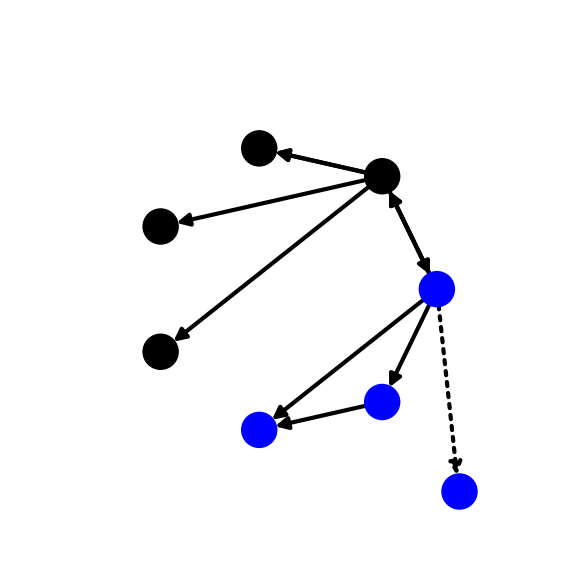

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25), dpi=300)

nx.draw_circular(H,
                 edge_color='k', width=1, style='-', arrowsize=6,
                 node_color=['bk'[i in range(1,5)] for i in G.nodes], node_size=60, node_shape='o');
pos2 = nx.circular_layout(H)

I = H.copy()
I.add_edge(0,7)

pos2[7] =  np.array([1.15, -1.4])

nx.draw(I, pos2, ax=ax, 
        edge_color='k', width=1, style=':', arrowsize=6, edgelist=[(0,7)], 
        node_color='b', nodelist=[7], node_size=60, node_shape='o')

ax.set_xlim(-1.8, 1.8), ax.set_ylim(-1.8, 1.8);

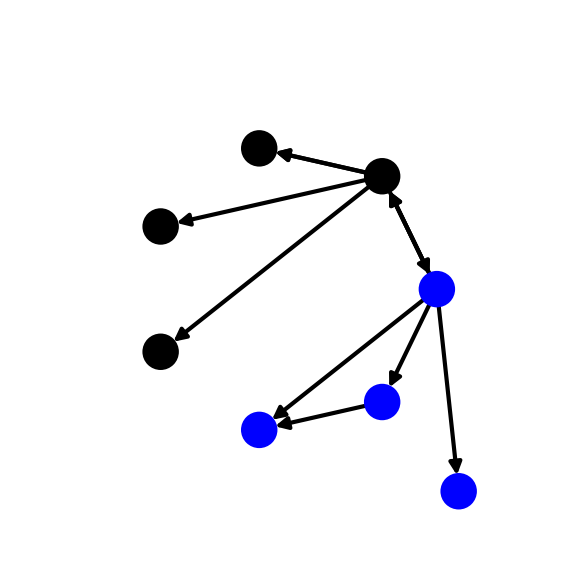

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(2.25,2.25), dpi=300)

nx.draw(I, pos2, ax=ax, 
        edge_color='k', width=1, style='-', arrowsize=6, 
        node_color=['bk'[i in range(1,5)] for i in I.nodes], node_size=60, node_shape='o')

ax.set_xlim(-1.8, 1.8), ax.set_ylim(-1.8, 1.8);

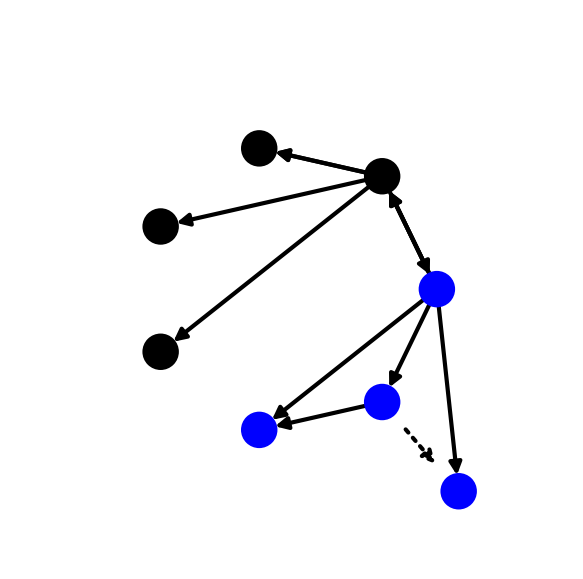

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(2.25,2.25), dpi=300)

nx.draw(I, pos2, ax=ax, 
        edge_color='k', width=1, style='-', arrowsize=6, 
        node_color=['bk'[i in range(1,5)] for i in I.nodes], node_size=60, node_shape='o')

J = I.copy()
if (6,7) not in J.edges():
    J.add_edge(6,7)

nx.draw_networkx_edges(J, pos2, ax=ax, 
                       edge_color='k', width=1, style=':', arrowsize=6, edgelist=[(6,7)])

ax.set_xlim(-1.8, 1.8), ax.set_ylim(-1.8, 1.8);

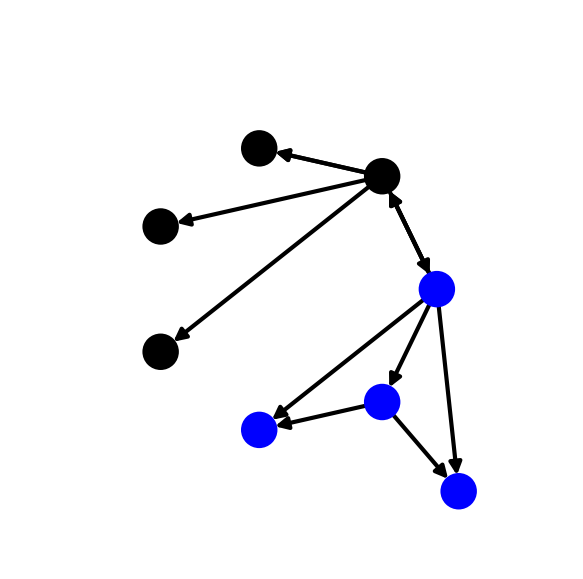

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(2.25,2.25), dpi=300)

nx.draw(J, pos2, ax=ax, 
        edge_color='k', width=1, style='-', arrowsize=6, 
        node_color=['bk'[i in range(1,5)] for i in I.nodes], node_size=60, node_shape='o')

ax.set_xlim(-1.8, 1.8), ax.set_ylim(-1.8, 1.8);

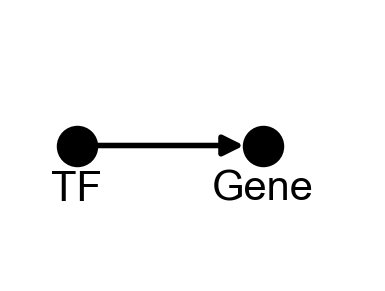

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(1.4,1), dpi=300)
nx.draw_planar(nx.DiGraph([('\n\nTF','\n\nGene')]), 
                 edge_color='k', width=1.33, style='-',
                 node_color='k', node_size=80, node_shape='o', with_labels=True, font_size=10); 
ax.set_xlim(-1.5, 2);